#Скачиваем необходимые для работы библиотеки

In [ ]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image

#Пример работы простого MatPlotLib кода

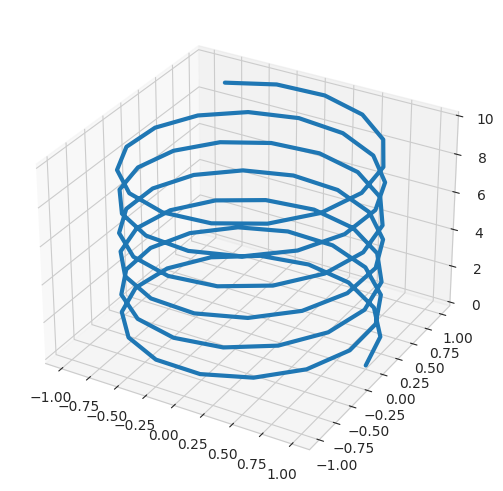

In [ ]:
sns.set_style("whitegrid")

OMEGA = 4

Z1 = np.linspace(0, 10, 100)
X1 = np.cos(OMEGA * Z1)
Y1 = np.sin(OMEGA * Z1)

plt.figure(figsize=(6, 5))
axes = plt.axes(projection="3d")
axes.plot3D(X1, Y1, Z1, lw=3)
# keeps padding between figure elements
plt.tight_layout()
plt.show()

## Пишем простую нейростеть на Pytorch (учебный пример)

# Инициализуем классы и функции

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    #target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

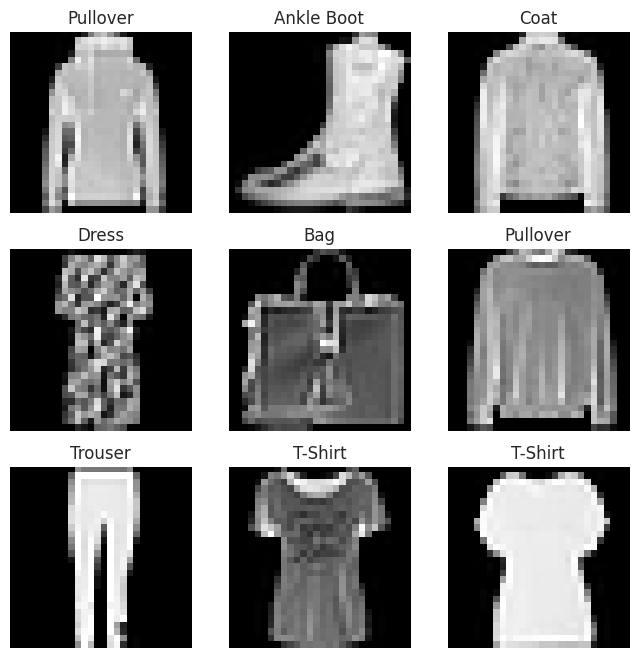

In [ ]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = "cuda"  # Use GPU if available
    device_name = torch.cuda.get_device_name(0)  # Get GPU name
    print(f"Using CUDA device: {device_name}")
else:
    device = "cpu"  # Use CPU if no GPU is available
    print("Using CPU device")

print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using CPU device
Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64, 10])


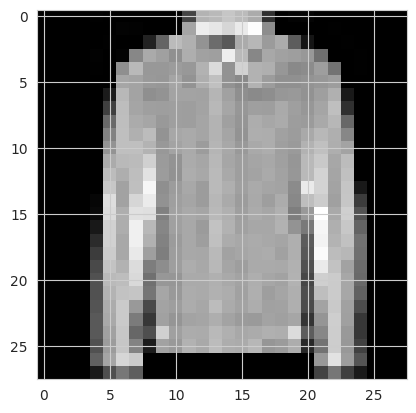

Label: tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296783  [   64/60000]
loss: 2.282207  [ 6464/60000]
loss: 2.273427  [12864/60000]
loss: 2.254368  [19264/60000]
loss: 2.263969  [25664/60000]
loss: 2.239775  [32064/60000]
loss: 2.196421  [38464/60000]
loss: 2.201881  [44864/60000]
loss: 2.181382  [51264/60000]
loss: 2.192666  [57664/60000]
Test Error: 
 Accuracy: 52.5%, Avg loss: 2.160866 

Epoch 2
-------------------------------
loss: 2.156999  [   64/60000]
loss: 2.145099  [ 6464/60000]
loss: 2.114870  [12864/60000]
loss: 2.088564  [19264/60000]
loss: 2.079057  [25664/60000]
loss: 2.000000  [32064/60000]
loss: 2.006501  [38464/60000]
loss: 2.007811  [44864/60000]
loss: 1.978124  [51264/60000]
loss: 1.939342  [57664/60000]
Test Error: 
 Accuracy: 60.4%, Avg loss: 1.898539 

Epoch 3
-------------------------------
loss: 1.907183  [   64/60000]
loss: 1.814994  [ 6464/60000]
loss: 1.882633  [12864/60000]
loss: 1.818854  [19264/60000]
loss: 1.780674  [25664/60000]
loss: 1.748561  [32064/600

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# Подробные материалы вступительного занятия (PyTorch)

# Играем с тензорами

In [ ]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

In [ ]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

In [ ]:
x_ones = torch.ones_like(x_data) # retains the properties of x_data
print(f"Ones Tensor: \n {x_ones} \n")

x_rand = torch.rand_like(x_data, dtype=torch.float) # overrides the datatype of x_data
print(f"Random Tensor: \n {x_rand} \n")

Ones Tensor: 
 tensor([[1, 1],
        [1, 1]]) 

Random Tensor: 
 tensor([[0.8490, 0.0925],
        [0.9799, 0.5881]]) 



In [ ]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.3217, 0.2307, 0.5091],
        [0.2203, 0.2229, 0.9830]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [ ]:
tensor = torch.rand(3,4)

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([3, 4])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [ ]:
tensor = torch.ones(4, 4)
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last column: {tensor[..., -1]}")
tensor[:,1] = 0
print(tensor)

First row: tensor([1., 1., 1., 1.])
First column: tensor([1., 1., 1., 1.])
Last column: tensor([1., 1., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [ ]:
t1 = torch.cat([tensor, tensor, tensor], dim=1)
print(t1)

tensor([[1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.]])


In [ ]:
# This computes the matrix multiplication between two tensors. y1, y2, y3 will have the same value
# ``tensor.T`` returns the transpose of a tensor
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

y3 = torch.rand_like(y1)
torch.matmul(tensor, tensor.T, out=y3)


# This computes the element-wise product. z1, z2, z3 will have the same value
z1 = tensor * tensor
z2 = tensor.mul(tensor)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out=z3)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])

In [ ]:
agg = tensor.sum()
agg_item = agg.item()
print(agg_item, type(agg_item))

12.0 <class 'float'>


In [ ]:
print(f"{tensor} \n")
tensor.add_(5)
print(tensor)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) 

tensor([[6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.],
        [6., 5., 6., 6.]])


In [ ]:
t = torch.ones(5)
print(f"t: {t}")
n = t.numpy()
print(f"n: {n}")

t: tensor([1., 1., 1., 1., 1.])
n: [1. 1. 1. 1. 1.]


In [ ]:
t.add_(1)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.])
n: [2. 2. 2. 2. 2.]


In [ ]:
n = np.ones(5)
t = torch.from_numpy(n)

In [ ]:
np.add(n, 1, out=n)
print(f"t: {t}")
print(f"n: {n}")

t: tensor([2., 2., 2., 2., 2.], dtype=torch.float64)
n: [2. 2. 2. 2. 2.]


In [ ]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8])


In [ ]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [ ]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [ ]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

torch.Size([3, 20])


In [ ]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

Before ReLU: tensor([[-0.2406, -0.3726, -0.2328,  0.0850, -0.0700,  0.5635, -0.4624,  0.0398,
          0.1828, -0.6749,  0.0143,  0.3771,  0.1975,  0.0959,  0.4411, -0.4244,
         -0.0133, -0.3180,  0.0394,  0.7700],
        [-0.1826, -0.2361, -0.3646,  0.2780,  0.1292,  0.0926, -0.5600,  0.4104,
          0.0768, -0.4290, -0.0916,  0.0720,  0.1677,  0.6582,  0.2921, -0.2910,
         -0.2594, -0.6934, -0.2289,  0.7030],
        [-0.0467, -0.1209, -0.1304,  0.2620, -0.2354, -0.0386, -0.2529,  0.3528,
          0.0675, -0.2511, -0.0873,  0.3079,  0.2788,  0.2902,  0.3382, -0.6420,
         -0.5451, -0.3756, -0.1693,  0.6488]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.0000, 0.0000, 0.0850, 0.0000, 0.5635, 0.0000, 0.0398, 0.1828,
         0.0000, 0.0143, 0.3771, 0.1975, 0.0959, 0.4411, 0.0000, 0.0000, 0.0000,
         0.0394, 0.7700],
        [0.0000, 0.0000, 0.0000, 0.2780, 0.1292, 0.0926, 0.0000, 0.4104, 0.0768,
         0.0000, 0.0000, 0.0720, 0.1677, 0.6582, 0.29

In [ ]:
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [ ]:
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0283, -0.0142,  0.0077,  ...,  0.0110, -0.0103,  0.0090],
        [-0.0322, -0.0222,  0.0078,  ...,  0.0276, -0.0200, -0.0298]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0210, -0.0020], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0097, -0.0062,  0.0344,  ...,  0.0586,  0.0161,  0.0040],
        [-0.0316, -0.0087,  0.0119,  ...,  0.0157,  0.0396, -0.0393]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

In [ ]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [ ]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7d29a973be50>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7d29a9a30460>


In [ ]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1114, 0.2414, 0.0779],
        [0.1114, 0.2414, 0.0779],
        [0.1114, 0.2414, 0.0779],
        [0.1114, 0.2414, 0.0779],
        [0.1114, 0.2414, 0.0779]])
tensor([0.1114, 0.2414, 0.0779])


In [ ]:
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad():
    z = torch.matmul(x, w)+b
print(z.requires_grad)

True
False


In [ ]:
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

False


In [ ]:
inp = torch.eye(4, 5, requires_grad=True)
out = (inp+1).pow(2).t()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"First call\n{inp.grad}")
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nSecond call\n{inp.grad}")
inp.grad.zero_()
out.backward(torch.ones_like(out), retain_graph=True)
print(f"\nCall after zeroing gradients\n{inp.grad}")

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


#Создаём простую нейросеть (прямой и обратный ход) с помощью numpy

In [ ]:

class NeuralNetwork1:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Инициализация нейронной сети.
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Инициализация весов и смещений случайными значениями
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_output = np.zeros((1, output_size))

    def sigmoid(self, x):
        """
        Сигмоидная функция активации.
        """
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        """
        Производная сигмоидной функции.
        """
        return x * (1 - x)

    def forward(self, input_data):
        """
        Прямое распространение (forward pass).
        """
        # Скрытый слой
        self.hidden_input = np.dot(input_data, self.weights_input_hidden) + self.bias_hidden
        self.hidden_activation = self.sigmoid(self.hidden_input)

        # Выходной слой
        self.output_input = np.dot(self.hidden_activation, self.weights_hidden_output) + self.bias_output
        self.output = self.sigmoid(self.output_input)

        return self.output, self.hidden_activation

    def backward(self, input_data, target, output, hidden_activation):
        """
        Обратное распространение (backward pass).
        """
        # Вычисление ошибки выходного слоя
        output_error = target - output
        output_delta = output_error * self.sigmoid_derivative(output)

        # Вычисление ошибки скрытого слоя
        hidden_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(hidden_activation)

        # Обновление весов и смещений
        self.weights_hidden_output += hidden_activation.T.dot(output_delta) * self.learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * self.learning_rate
        self.weights_input_hidden += input_data.T.dot(hidden_delta) * self.learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * self.learning_rate


    def train(self, input_data, target, epochs=10000):
        """
        Обучение нейронной сети.
        """
        for epoch in range(epochs):
            output, hidden_activation = self.forward(input_data)
            self.backward(input_data, target, output, hidden_activation)

            if epoch % 1000 == 0:
                loss = np.mean(np.square(target - output)) # MSE Loss
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, input_data):
        """
        Предсказание выходных данных для новых входных данных.
        """
        output, _ = self.forward(input_data)
        return output

    def get_weights(self):
        """
        Возвращает веса нейронной сети.
        """
        return {
            "weights_input_hidden": self.weights_input_hidden,
            "bias_hidden": self.bias_hidden,
            "weights_hidden_output": self.weights_hidden_output,
            "bias_output": self.bias_output,
        }

    def set_weights(self, weights):
        """
        Устанавливает веса нейронной сети.
        """
        self.weights_input_hidden = weights["weights_input_hidden"]
        self.bias_hidden = weights["bias_hidden"]
        self.weights_hidden_output = weights["weights_hidden_output"]
        self.bias_output = weights["bias_output"]

    def get_gradients(self, input_data, target, output, hidden_activation):
        """
        Вычисляет градиенты для всех весов и смещений.
        """
        # Вычисление ошибки выходного слоя
        output_error = target - output
        output_delta = output_error * self.sigmoid_derivative(output)

        # Вычисление ошибки скрытого слоя
        hidden_error = output_delta.dot(self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(hidden_activation)

        # Вычисление градиентов
        d_weights_hidden_output = hidden_activation.T.dot(output_delta)
        d_bias_output = np.sum(output_delta, axis=0, keepdims=True)
        d_weights_input_hidden = input_data.T.dot(hidden_delta)
        d_bias_hidden = np.sum(hidden_delta, axis=0, keepdims=True)

        return {
            "weights_hidden_output": d_weights_hidden_output,
            "bias_output": d_bias_output,
            "weights_input_hidden": d_weights_input_hidden,
            "bias_hidden": d_bias_hidden,
        }

    def apply_gradients(self, gradients):
        """
        Применяет градиенты к весам и смещениям.
        """
        self.weights_hidden_output += gradients["weights_hidden_output"] * self.learning_rate
        self.bias_output += gradients["bias_output"] * self.learning_rate
        self.weights_input_hidden += gradients["weights_input_hidden"] * self.learning_rate
        self.bias_hidden += gradients["bias_hidden"] * self.learning_rate

    def single_backward(self, input_data, target):
        """
        Выполняет один шаг обратного распространения и возвращает градиенты.
        """
        output, hidden_activation = self.forward(input_data)
        gradients = self.get_gradients(input_data, target, output, hidden_activation)
        return gradients

    def train_with_gradients(self, input_data, target, epochs=10000):
        """
        Обучение нейронной сети, используя отдельные этапы вычисления и применения градиентов.
        """
        for epoch in range(epochs):
            # Вычисление градиентов
            gradients = self.single_backward(input_data, target)

            # Применение градиентов
            self.apply_gradients(gradients)

            if epoch % 1000 == 0:
                output, _ = self.forward(input_data)
                loss = np.mean(np.square(target - output))
                print(f"Epoch {epoch}, Loss: {loss}")


# Пример использования
if __name__ == "__main__":
    # Определение параметров сети
    input_size = 2
    hidden_size = 3
    output_size = 1
    learning_rate = 0.1

    # Создание нейронной сети
    nn = NeuralNetwork1(input_size, hidden_size, output_size, learning_rate)

    # Обучающие данные (пример задачи XOR)
    input_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    target = np.array([[0], [1], [1], [0]])

    # Обучение сети с разделением этапов backward pass
    nn.train_with_gradients(input_data, target, epochs=10000)

    # Предсказание для новых данных
    predictions = nn.predict(input_data)
    print("Predictions:")
    print(predictions)

Epoch 0, Loss: 0.28299495627536886
Epoch 1000, Loss: 0.18942298229305624
Epoch 2000, Loss: 0.15439263230490607
Epoch 3000, Loss: 0.1408070805707473
Epoch 4000, Loss: 0.13513898771599772
Epoch 5000, Loss: 0.13226224647744314
Epoch 6000, Loss: 0.13057447236817554
Epoch 7000, Loss: 0.12948059958905178
Epoch 8000, Loss: 0.12871963268267814
Epoch 9000, Loss: 0.1281616297237999
Predictions:
[[0.04132508]
 [0.95039547]
 [0.49807183]
 [0.50481951]]


## 🏆Первый вариант переписывания нейронной сети из примера PyTorch на Numpy (ровно по образцу)


```
📝Распределение: Веса инициализируются из равномерного распределения U(-√k, √k), где k = 1 / in_features.

⭐Форма: (out_features, in_features) — обратный порядок. Это стандарт PyTorch, где сначала указывается число выходных признаков, а затем входных.

🛠️Масштабирование: Границы распределения — ±√(1 / in_features). Дисперсия равномерного распределения U(-a, a) равна (2a)²/12 = a²/3, где a = √(1 / in_features). Таким образом, дисперсия весов равна (1 / in_features) / 3 = 1 / (3 * in_features).

📌Назначение: Это вариант инициализации Глорота (Xavier initialization) с равномерным распределением, который лучше подходит для активаций типа tanh или sigmoid. Он стремится сохранить дисперсию активаций и градиентов на уровне 1.
```

Train images shape: (60000, 784), type: float32, images_len: 60000
Train labels shape: (60000,), type: int64, labels_len: 60000
Test images shape: (10000, 784), type: float32, images_len: 10000
Test labels shape: (10000, 784), type: float32, labels_len: 10000
Description of training images:
                0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000003      0.000023      0.000118      0.000407      0.000979   
std        0.000363      0.000976      0.003009      0.009850      0.016987   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.062745      0.141176      0.466667      0.643137      0.878431 

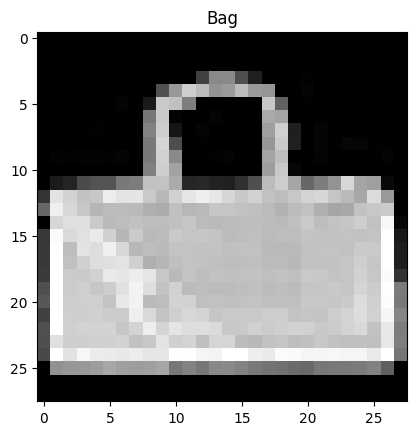

Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Training...
Epoch 1
-------------------------------
Epoch 1 - Loss: 2.3141220  [   64/60000]
Epoch 1 - Loss: 2.2737451  [ 6464/60000]
Epoch 1 - Loss: 2.2596716  [12864/60000]
Epoch 1 - Loss: 2.2594440  [19264/60000]
Epoch 1 - Loss: 2.2543499  [25664/60000]
Epoch 1 - Loss: 2.2239949  [32064/60000]
Epoch 1 - Loss: 2.2237149  [38464/60000]
Epoch 1 - Loss: 2.2029639  [44864/60000]
Epoch 1 - Loss: 2.1892161  [51264/60000]
Epoch 1 - Loss: 2.1826912  [57664/60000]
Training Epoch 1 - Mean: 2.2379216 - Median: 2.2396572
Training Epoch 1 - Output Mean: 2.2383914 - Output Median: 2.2391724
Training finished.
Average loss: 2.2403099 -- Accuracy: 31.9%, 

Train Precision: 0.43959 -- Recall: 0.31937 -- F1-Score: 0.25656

Training Average MSE: 0.0887734

Total running time of the epoch script: (0 minutes 27.414 seconds)
Testing Mean: 2.1634458 - Median: 2.1628809
Testing Error: 
Accuracy: 46.3%, Average loss: 2.177314 

Testing Precision: 0.51996 -- Recall: 0.46

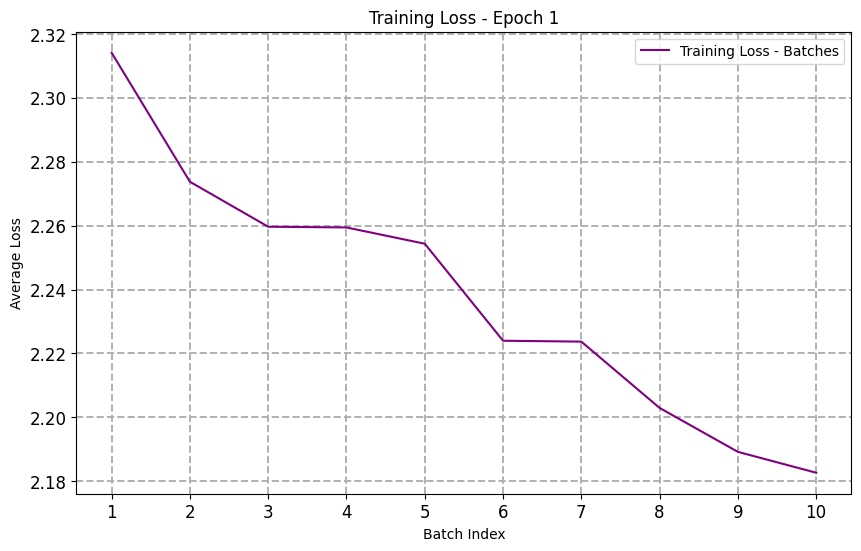

Epoch 2
-------------------------------
Epoch 2 - Loss: 2.1586588  [   64/60000]
Epoch 2 - Loss: 2.1422917  [ 6464/60000]
Epoch 2 - Loss: 2.1253713  [12864/60000]
Epoch 2 - Loss: 2.1118846  [19264/60000]
Epoch 2 - Loss: 2.0618718  [25664/60000]
Epoch 2 - Loss: 2.0275184  [32064/60000]
Epoch 2 - Loss: 1.9985289  [38464/60000]
Epoch 2 - Loss: 1.9796723  [44864/60000]
Epoch 2 - Loss: 1.9746784  [51264/60000]
Epoch 2 - Loss: 1.8667486  [57664/60000]
Training Epoch 2 - Mean: 2.0484729 - Median: 2.0555852
Training Epoch 2 - Output Mean: 2.0447225 - Output Median: 2.0446951
Training finished.
Average loss: 2.0506591 -- Accuracy: 53.5%, 

Train Precision: 0.52557 -- Recall: 0.53502 -- F1-Score: 0.49128

Training Average MSE: 0.0845530

Total running time of the epoch script: (0 minutes 27.661 seconds)
Testing Mean: 1.9069153 - Median: 1.9071573
Testing Error: 
Accuracy: 55.2%, Average loss: 1.919139 

Testing Precision: 0.54699 -- Recall: 0.55240 -- F1-Score: 0.49904

Testing Average MSE: 0.08

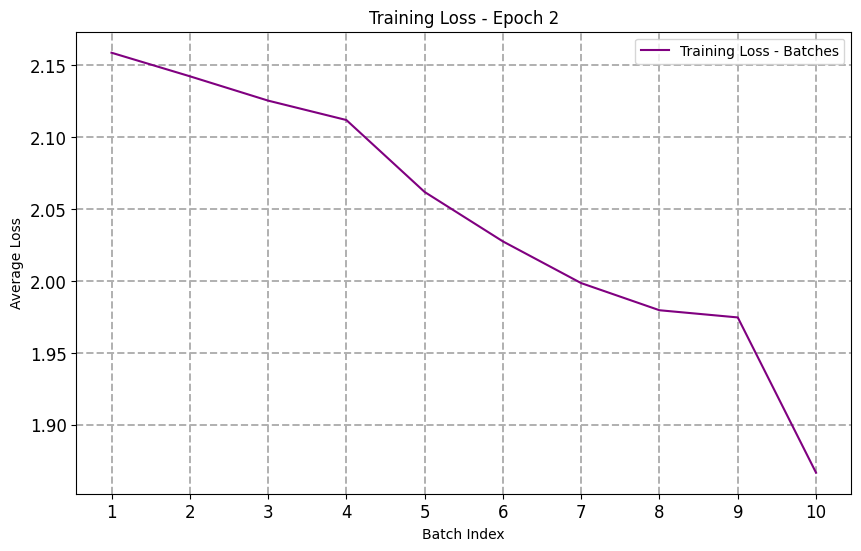

Epoch 3
-------------------------------
Epoch 3 - Loss: 1.8757345  [   64/60000]
Epoch 3 - Loss: 1.8112439  [ 6464/60000]
Epoch 3 - Loss: 1.8389995  [12864/60000]
Epoch 3 - Loss: 1.7978997  [19264/60000]
Epoch 3 - Loss: 1.7144396  [25664/60000]
Epoch 3 - Loss: 1.8051124  [32064/60000]
Epoch 3 - Loss: 1.6404039  [38464/60000]
Epoch 3 - Loss: 1.6614027  [44864/60000]
Epoch 3 - Loss: 1.5557609  [51264/60000]
Epoch 3 - Loss: 1.5575345  [57664/60000]
Training Epoch 3 - Mean: 1.7234907 - Median: 1.7263783
Training Epoch 3 - Output Mean: 1.7258532 - Output Median: 1.7561697
Training finished.
Average loss: 1.7253300 -- Accuracy: 57.8%, 

Train Precision: 0.55798 -- Recall: 0.57807 -- F1-Score: 0.52380

Training Average MSE: 0.0757366

Total running time of the epoch script: (0 minutes 27.752 seconds)
Testing Mean: 1.5480390 - Median: 1.5473571
Testing Error: 
Accuracy: 59.8%, Average loss: 1.557962 

Testing Precision: 0.53776 -- Recall: 0.59820 -- F1-Score: 0.53763

Testing Average MSE: 0.07

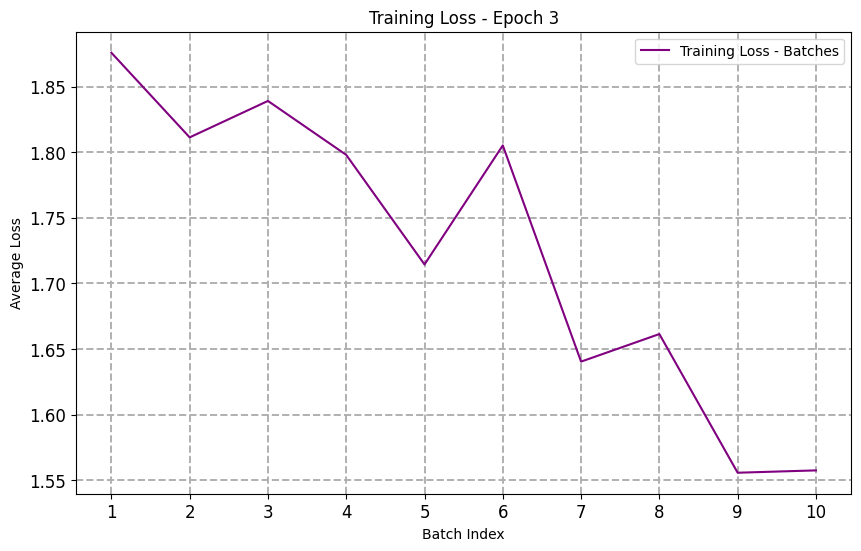

Epoch 4
-------------------------------
Epoch 4 - Loss: 1.5652845  [   64/60000]
Epoch 4 - Loss: 1.5950689  [ 6464/60000]
Epoch 4 - Loss: 1.5005938  [12864/60000]
Epoch 4 - Loss: 1.4519469  [19264/60000]
Epoch 4 - Loss: 1.3756747  [25664/60000]
Epoch 4 - Loss: 1.4492296  [32064/60000]
Epoch 4 - Loss: 1.3377192  [38464/60000]
Epoch 4 - Loss: 1.3559023  [44864/60000]
Epoch 4 - Loss: 1.3330247  [51264/60000]
Epoch 4 - Loss: 1.2416205  [57664/60000]
Training Epoch 4 - Mean: 1.3995425 - Median: 1.3990909
Training Epoch 4 - Output Mean: 1.4206065 - Output Median: 1.4124522
Training finished.
Average loss: 1.4010361 -- Accuracy: 62.1%, 

Train Precision: 0.65482 -- Recall: 0.62132 -- F1-Score: 0.56093

Training Average MSE: 0.0652890

Total running time of the epoch script: (0 minutes 28.438 seconds)
Testing Mean: 1.2810848 - Median: 1.2810361
Testing Error: 
Accuracy: 61.8%, Average loss: 1.289297 

Testing Precision: 0.62393 -- Recall: 0.61810 -- F1-Score: 0.55747

Testing Average MSE: 0.06

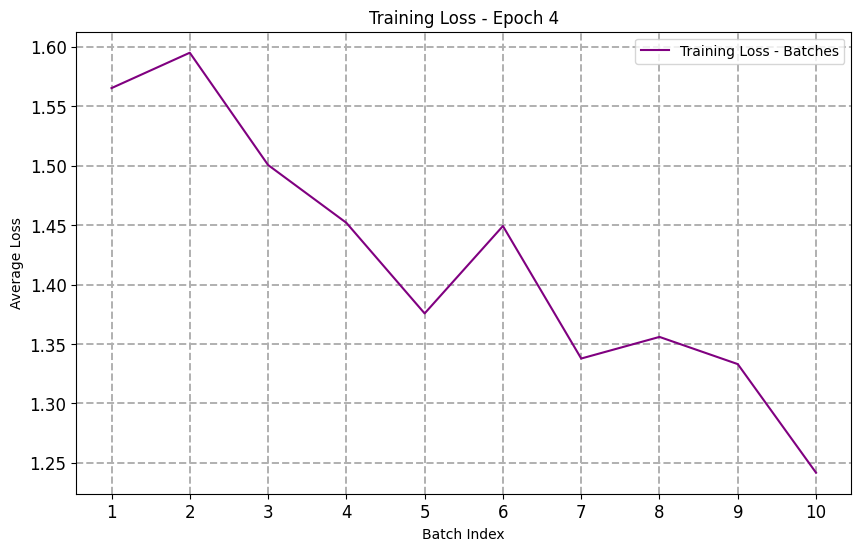

Epoch 5
-------------------------------
Epoch 5 - Loss: 1.3676341  [   64/60000]
Epoch 5 - Loss: 1.2681373  [ 6464/60000]
Epoch 5 - Loss: 1.0999040  [12864/60000]
Epoch 5 - Loss: 1.2165155  [19264/60000]
Epoch 5 - Loss: 1.2746640  [25664/60000]
Epoch 5 - Loss: 1.1874403  [32064/60000]
Epoch 5 - Loss: 1.2035167  [38464/60000]
Epoch 5 - Loss: 1.2004450  [44864/60000]
Epoch 5 - Loss: 1.1847354  [51264/60000]
Epoch 5 - Loss: 1.0093898  [57664/60000]
Training Epoch 5 - Mean: 1.1838454 - Median: 1.1852673
Training Epoch 5 - Output Mean: 1.2012382 - Output Median: 1.2019808
Training finished.
Average loss: 1.1851089 -- Accuracy: 64.1%, 

Train Precision: 0.66206 -- Recall: 0.64053 -- F1-Score: 0.58410

Training Average MSE: 0.0570123

Total running time of the epoch script: (0 minutes 28.154 seconds)
Testing Mean: 1.1130125 - Median: 1.1076185
Testing Error: 
Accuracy: 64.2%, Average loss: 1.120147 

Testing Precision: 0.65656 -- Recall: 0.64240 -- F1-Score: 0.58959

Testing Average MSE: 0.05

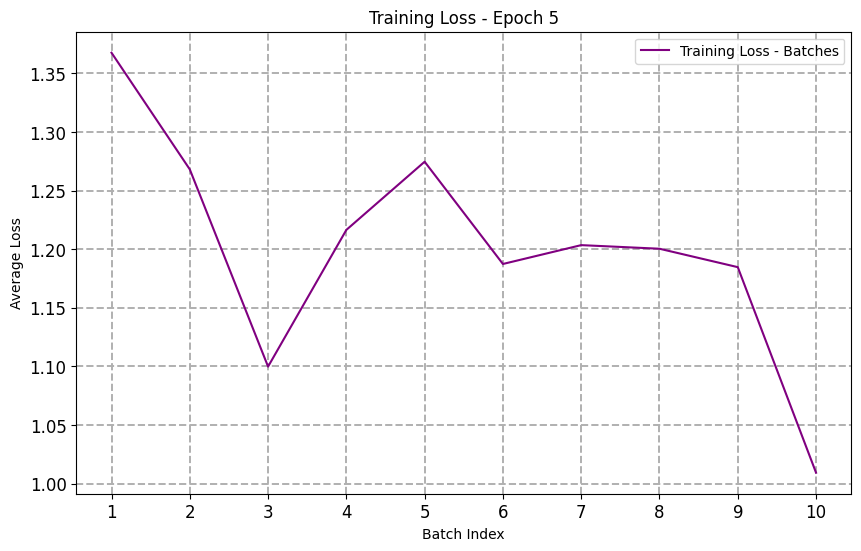

Epoch 6
-------------------------------
Epoch 6 - Loss: 1.2044527  [   64/60000]
Epoch 6 - Loss: 0.9190103  [ 6464/60000]
Epoch 6 - Loss: 1.0964563  [12864/60000]
Epoch 6 - Loss: 1.0096321  [19264/60000]
Epoch 6 - Loss: 1.0943097  [25664/60000]
Epoch 6 - Loss: 1.0606183  [32064/60000]
Epoch 6 - Loss: 1.0844298  [38464/60000]
Epoch 6 - Loss: 0.9905053  [44864/60000]
Epoch 6 - Loss: 0.9769771  [51264/60000]
Epoch 6 - Loss: 1.0721149  [57664/60000]
Training Epoch 6 - Mean: 1.0449686 - Median: 1.0462648
Training Epoch 6 - Output Mean: 1.0508506 - Output Median: 1.0663666
Training finished.
Average loss: 1.0460838 -- Accuracy: 65.8%, 

Train Precision: 0.67913 -- Recall: 0.65820 -- F1-Score: 0.60880

Training Average MSE: 0.0510476

Total running time of the epoch script: (0 minutes 28.988 seconds)
Testing Mean: 1.0018932 - Median: 1.0014937
Testing Error: 
Accuracy: 64.9%, Average loss: 1.008316 

Testing Precision: 0.66168 -- Recall: 0.64910 -- F1-Score: 0.59944

Testing Average MSE: 0.04

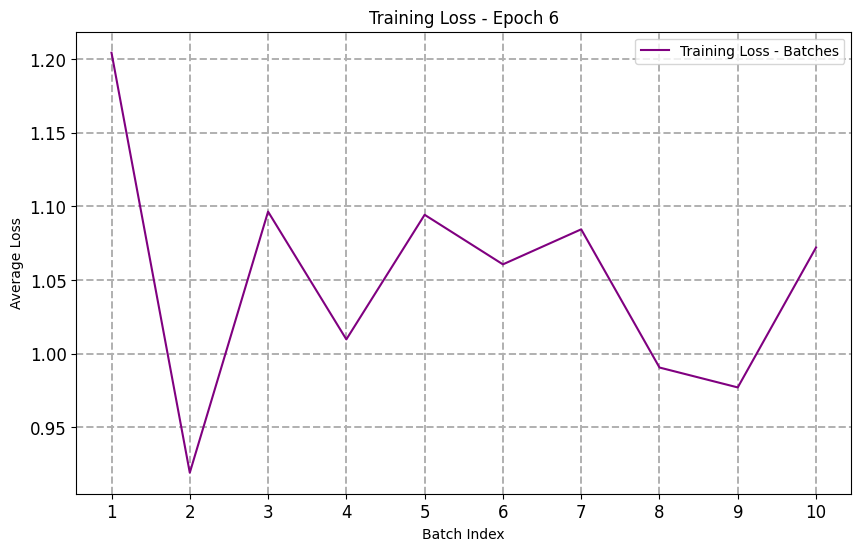

Epoch 7
-------------------------------
Epoch 7 - Loss: 1.0411493  [   64/60000]
Epoch 7 - Loss: 0.9716308  [ 6464/60000]
Epoch 7 - Loss: 0.9815024  [12864/60000]
Epoch 7 - Loss: 1.0195449  [19264/60000]
Epoch 7 - Loss: 0.9102718  [25664/60000]
Epoch 7 - Loss: 0.8653534  [32064/60000]
Epoch 7 - Loss: 1.0694937  [38464/60000]
Epoch 7 - Loss: 0.9061485  [44864/60000]
Epoch 7 - Loss: 0.9306345  [51264/60000]
Epoch 7 - Loss: 0.8353493  [57664/60000]
Training Epoch 7 - Mean: 0.9510421 - Median: 0.9490203
Training Epoch 7 - Output Mean: 0.9531079 - Output Median: 0.9511326
Training finished.
Average loss: 0.9520571 -- Accuracy: 67.4%, 

Train Precision: 0.69173 -- Recall: 0.67357 -- F1-Score: 0.63383

Training Average MSE: 0.0469204

Total running time of the epoch script: (0 minutes 28.591 seconds)
Testing Mean: 0.9248068 - Median: 0.9219922
Testing Error: 
Accuracy: 66.4%, Average loss: 0.930735 

Testing Precision: 0.67908 -- Recall: 0.66440 -- F1-Score: 0.62756

Testing Average MSE: 0.04

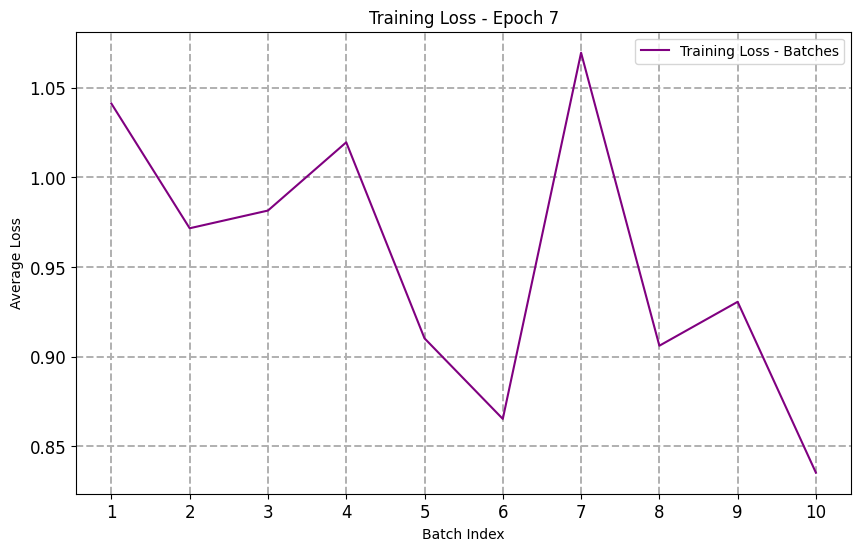

Epoch 8
-------------------------------
Epoch 8 - Loss: 1.0477798  [   64/60000]
Epoch 8 - Loss: 0.9165936  [ 6464/60000]
Epoch 8 - Loss: 0.8046396  [12864/60000]
Epoch 8 - Loss: 0.9382232  [19264/60000]
Epoch 8 - Loss: 0.8474689  [25664/60000]
Epoch 8 - Loss: 0.9217416  [32064/60000]
Epoch 8 - Loss: 0.9354991  [38464/60000]
Epoch 8 - Loss: 0.9045131  [44864/60000]
Epoch 8 - Loss: 1.0045161  [51264/60000]
Epoch 8 - Loss: 0.9030961  [57664/60000]
Training Epoch 8 - Mean: 0.8841922 - Median: 0.8773394
Training Epoch 8 - Output Mean: 0.9224071 - Output Median: 0.9191676
Training finished.
Average loss: 0.8851359 -- Accuracy: 68.6%, 

Train Precision: 0.69990 -- Recall: 0.68633 -- F1-Score: 0.65509

Training Average MSE: 0.0440198

Total running time of the epoch script: (0 minutes 28.858 seconds)
Testing Mean: 0.8697444 - Median: 0.8738966
Testing Error: 
Accuracy: 67.2%, Average loss: 0.875320 

Testing Precision: 0.68223 -- Recall: 0.67210 -- F1-Score: 0.64145

Testing Average MSE: 0.04

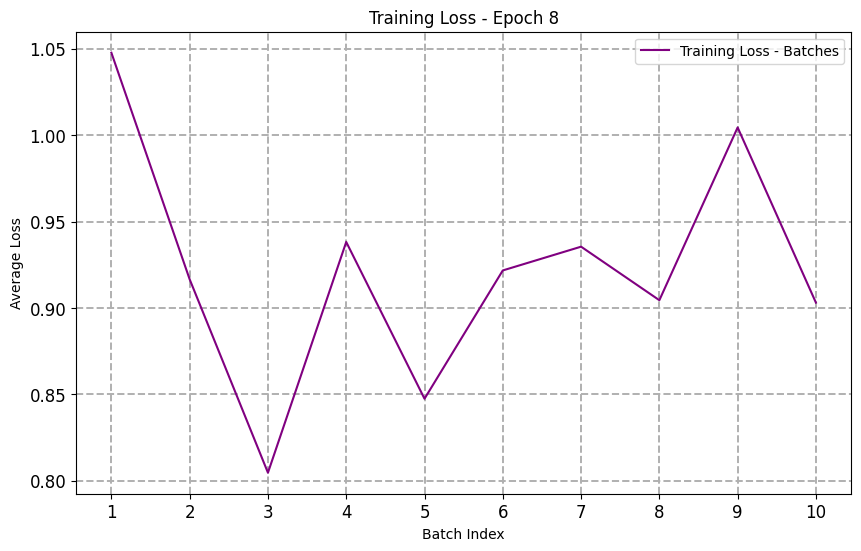

Epoch 9
-------------------------------
Epoch 9 - Loss: 0.8135582  [   64/60000]
Epoch 9 - Loss: 0.7846859  [ 6464/60000]
Epoch 9 - Loss: 0.7778696  [12864/60000]
Epoch 9 - Loss: 0.9047822  [19264/60000]
Epoch 9 - Loss: 0.9193131  [25664/60000]
Epoch 9 - Loss: 0.9002604  [32064/60000]
Epoch 9 - Loss: 0.8911856  [38464/60000]
Epoch 9 - Loss: 0.9013075  [44864/60000]
Epoch 9 - Loss: 0.8372607  [51264/60000]
Epoch 9 - Loss: 0.8707452  [57664/60000]
Training Epoch 9 - Mean: 0.8351038 - Median: 0.8318321
Training Epoch 9 - Output Mean: 0.8600968 - Output Median: 0.8809654
Training finished.
Average loss: 0.8359951 -- Accuracy: 69.9%, 

Train Precision: 0.70748 -- Recall: 0.69883 -- F1-Score: 0.67448

Training Average MSE: 0.0418968

Total running time of the epoch script: (0 minutes 28.504 seconds)
Testing Mean: 0.8289483 - Median: 0.8213342
Testing Error: 
Accuracy: 69.1%, Average loss: 0.834262 

Testing Precision: 0.70054 -- Recall: 0.69060 -- F1-Score: 0.66851

Testing Average MSE: 0.04

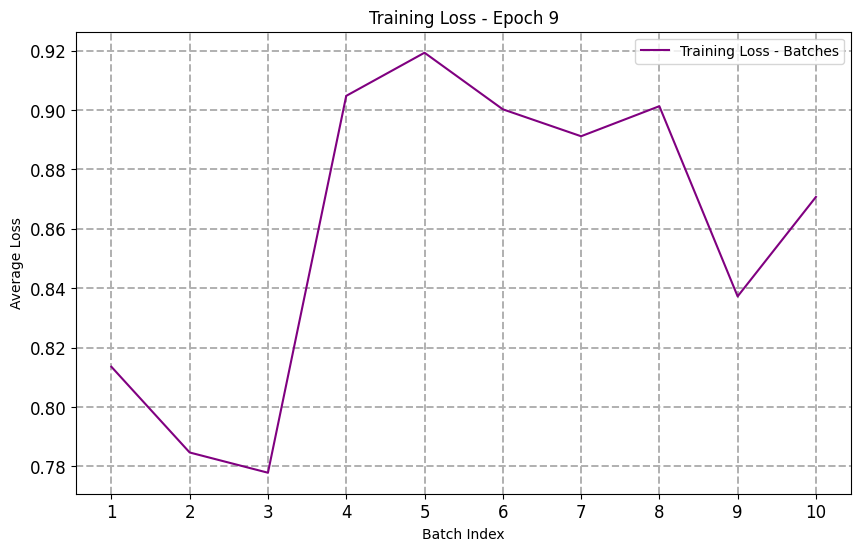

Epoch 10
-------------------------------
Epoch 10 - Loss: 0.9574951  [   64/60000]
Epoch 10 - Loss: 0.9049979  [ 6464/60000]
Epoch 10 - Loss: 0.7965061  [12864/60000]
Epoch 10 - Loss: 0.8157781  [19264/60000]
Epoch 10 - Loss: 0.7587951  [25664/60000]
Epoch 10 - Loss: 0.7715004  [32064/60000]
Epoch 10 - Loss: 0.7374057  [38464/60000]
Epoch 10 - Loss: 0.7923079  [44864/60000]
Epoch 10 - Loss: 0.7435944  [51264/60000]
Epoch 10 - Loss: 0.8121352  [57664/60000]
Training Epoch 10 - Mean: 0.7971014 - Median: 0.7935118
Training Epoch 10 - Output Mean: 0.8090516 - Output Median: 0.7944070
Training finished.
Average loss: 0.7979521 -- Accuracy: 70.9%, 

Train Precision: 0.71442 -- Recall: 0.70943 -- F1-Score: 0.69098

Training Average MSE: 0.0402492

Total running time of the epoch script: (0 minutes 28.223 seconds)
Testing Mean: 0.7977735 - Median: 0.7841663
Testing Error: 
Accuracy: 70.2%, Average loss: 0.802887 

Testing Precision: 0.70221 -- Recall: 0.70250 -- F1-Score: 0.68344

Testing Aver

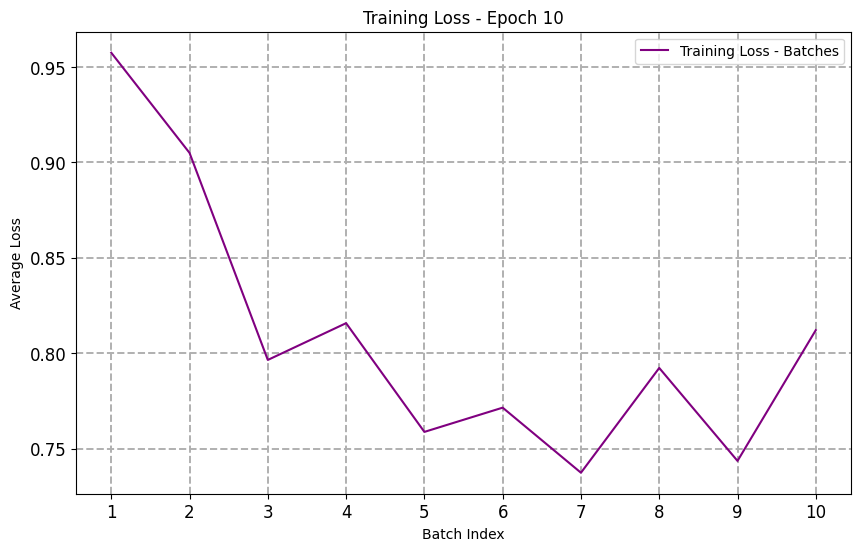

Done!
Saved NumPy Model State to numpy_model.pkl
Loaded NumPy Model State from numpy_model.pkl
Длина labels_map: 10
Predicted: Shirt, Actual: Shirt


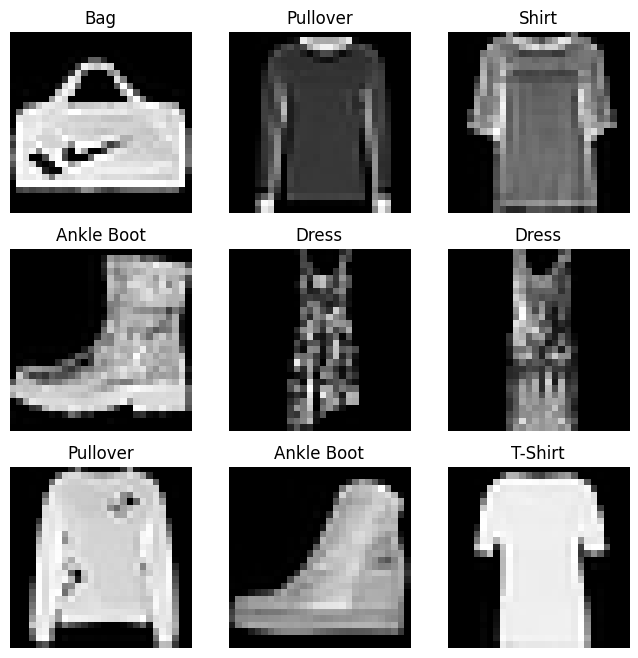

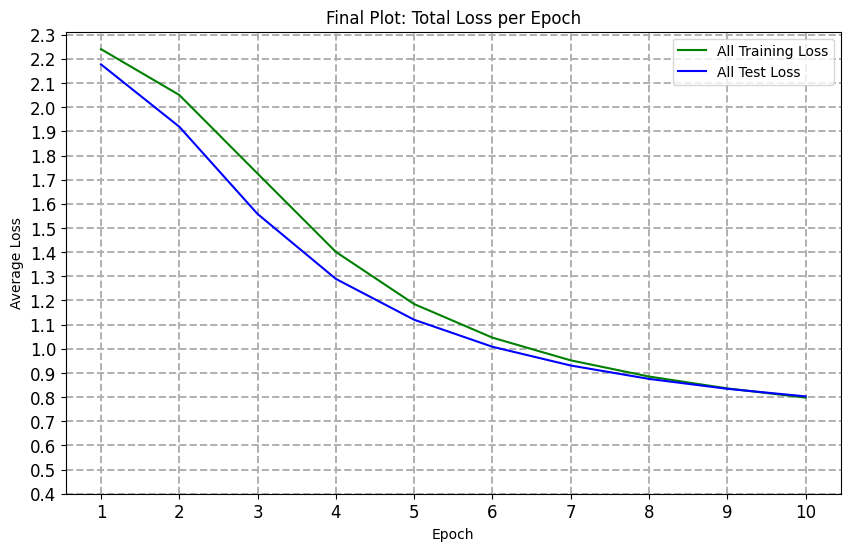

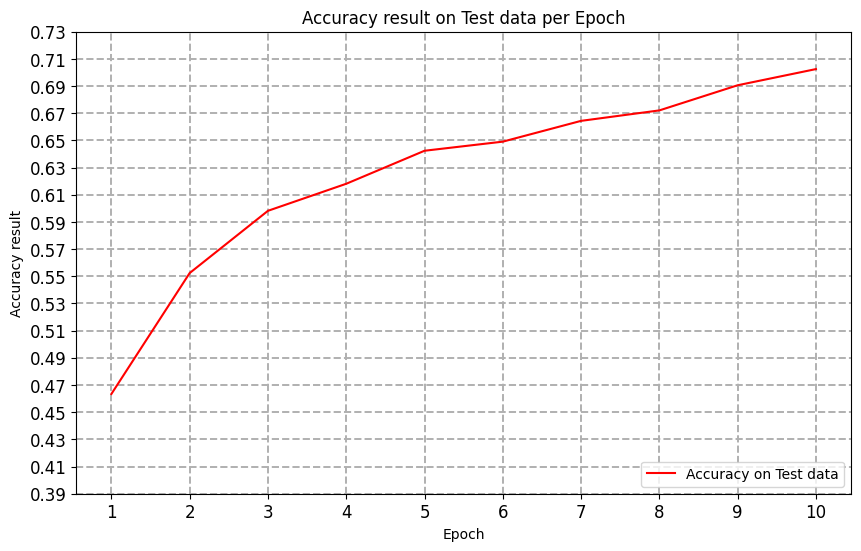

Total running time of the script: (5 minutes 9.790 seconds)
Script started at: 2025-03-17 14:44:53
Script ended at: 2025-03-17 14:50:03
time.struct_time(tm_year=2025, tm_mon=3, tm_mday=17, tm_hour=14, tm_min=50, tm_sec=3, tm_wday=0, tm_yday=76, tm_isdst=0)


In [10]:
# Импортируемые библиотеки
import numpy as np
import pandas as pd
from torchvision import datasets
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from dataclasses import dataclass, field
from typing import Optional
import time
import statistics
import random
import warnings; warnings.filterwarnings(action='once')

# Инициализация глобальных параметров
@dataclass(frozen=True)
class Constants:
    input_size: int = 28 * 28
    segment_size: int = 28
    hidden_size: int = 512
    output_size: int = 10
    learning_rate: float = 1e-3
    tolerance: float = 1e-15
    epochs: int = 10
    batch_size: int = 64
    report_interval: int = 100
    num_images: int = 9
    num_classes: int = 10
    pixel_value: float = 255.0
    filename: Optional[str] = field(default=None,
                                    init=False)

    def __post_init__(self):
        object.__setattr__(self,
                           'filename',
                           "numpy_model.pkl")

MY_CONSTANTS = Constants()

# Загружаем массив подписей
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

"""
[EN] Function that loads FashionMNIST dataset and preprocesses it for NumPy-based Neural Network.
[RU] Функция, которая загружает FashionMNIST датасет и подготавливает его для NumPy-based Neural Network
"""
def load_fashion_mnist(train=True,
                       flatten=True,
                       normalize=True):
    try:
        data = datasets.FashionMNIST(root="data", train=train, download=True)
    except Exception as e:
        print(f"Error loading FashionMNIST: {e}")
        return None, None
    num_samples = len(data)
    img_shape = data[0][0].size
    if flatten:
        img_size = img_shape[0] * img_shape[1]
        images = np.zeros((num_samples, img_size), dtype=np.float32)
    else:
        images = np.zeros((num_samples, img_shape[0], img_shape[1]), dtype=np.float32)
    labels = np.zeros(num_samples, dtype=np.int64)

    for idx, (img, label) in enumerate(data):

        # Converting to float32
        img_np = np.array(img, dtype=np.float32)
        if normalize:

            # Normalize pixel values
            img_np /= MY_CONSTANTS.pixel_value
        if flatten:
            img_np = img_np.flatten()

        images[idx] = img_np
        labels[idx] = label

    return images, labels

"""
[EN] Function that display a grid of random images from the dataset.
[RU] Функция для вывода графика рандомных изображений из  датасета
"""
def display_random_images(images,
                          labels,
                          labels_map,
                          num_images=MY_CONSTANTS.num_images):
      figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, num_images + 1):
          sample_idx = np.random.randint(0, len(images))
          img = images[sample_idx]
          label = labels[sample_idx]
          figure.add_subplot(rows, cols, i)
          plt.title(labels_map[label])
          plt.axis("off")
          plt.imshow(img.reshape(MY_CONSTANTS.segment_size,
                                 MY_CONSTANTS.segment_size),
                     cmap="gray")
      plt.show()

"""
[EN] Function that prints a cycle graph.
[RU] Функция для вывода графика-тренировки в цикле
"""
def print_cycle_graph(batch_indices,
                      batch_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(batch_indices, batch_losses, label="Training Loss - Batches", color="purple")
    plt.xlabel("Batch Index")
    plt.ylabel("Average Loss")
    plt.title(f"Training Loss - Epoch {epoch_count}")
    plt.grid(True, linestyle='--', linewidth = "1.4")
    plt.yticks(fontsize=12)
    plt.xticks(range(1, 11), fontsize=12)
    plt.legend(["Training Loss - Batches"])
    plt.show()

"""
[EN] Function that returns a loss-function graph.
[RU] Функция для вывода графика функции потерь
"""
def print_result_graph(avg_loss_train,
                       avg_loss_test):
  epochs = range(1, len(avg_loss_train) + 1)
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, avg_loss_train, label="All Training Loss", color='green') # Plot all train losses
  plt.plot(epochs, avg_loss_test, label="All Test Loss", color='blue') # Plot all test losses
  plt.xlabel("Epoch")
  plt.ylabel("Average Loss")
  plt.title("Final Plot: Total Loss per Epoch")
  plt.grid(True, linestyle='--', linewidth = "1.4")
  plt.xticks(range(1, 11), fontsize=12)
  plt.yticks(np.arange(0.4, 2.4, 0.1), fontsize=12)
  plt.legend()
  plt.show()

"""
[EN] Function that returns a test-accuracy graph.
[RU] Функция для вывода графика точности на тесте
"""
def print_accuracy_graph(accuracy_test):
  epochs = range(1, len(avg_loss_train) + 1)
  plt.figure(figsize=(10,6))
  plt.plot(epochs, accuracy_test, color="red", label="Accuracy on Test data") # Plot test accuracy
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy result")
  plt.title("Accuracy result on Test data per Epoch")
  plt.grid(True, linestyle='--', linewidth='1.4')
  plt.xticks(range(1, 11), fontsize=12)
  plt.yticks(np.arange(0.39, 0.75, 0.02), fontsize=12)
  plt.legend(loc='lower right')
  plt.show()

"""
[EN] Function that creates batches of data from NumPy arrays.
[RU] Функция для создания серий из данных на основе массивов NumPy
"""
def create_batches(images,
                   labels,
                   batch_size=MY_CONSTANTS.batch_size,
                   shuffle=True,
                   reshape=True):
    num_samples = images.shape[0]
    if shuffle:
        permutation = np.random.permutation(num_samples)
        images = images[permutation]
        labels = labels[permutation]
    for i in range(0, num_samples, batch_size):
        batch_images = images[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        if reshape:
             batch_images = batch_images.reshape(-1,
                                                 MY_CONSTANTS.segment_size,
                                                 MY_CONSTANTS.segment_size)
             batch_images = np.expand_dims(batch_images, axis=1)
        yield batch_images, batch_labels

"""
[EN] Function that encodes the labels.
[RU] Функция для кодирования подписей
"""
def label_encode(labels,
                 num_classes=MY_CONSTANTS.num_classes):
    encoded_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
    encoded_labels[np.arange(len(labels)), labels] = 1
    return encoded_labels

# Выставляем стартовое время работы алгоритма
start_time = time.time()

# Загружаем тренировочный датасет
train_images, train_labels = load_fashion_mnist(train=True,
                                                flatten=True,
                                                normalize=True)
# Загружаем тестовый датасет
test_images, test_labels = load_fashion_mnist(train=False,
                                              flatten=True,
                                              normalize=True)

# Выводим данные датасетов - размер, тип и длину
print(f"Train images shape: {train_images.shape}, type: {train_images.dtype}, images_len: {len(train_images)}")
print(f"Train labels shape: {train_labels.shape}, type: {train_labels.dtype}, labels_len: {len(train_labels)}")
print(f"Test images shape: {test_images.shape}, type: {test_images.dtype}, images_len: {len(test_images)}")
print(f"Test labels shape: {test_images.shape}, type: {test_images.dtype}, labels_len: {len(test_images)}")

# Using pandas DataFrame function to take information about dataset
# Пробуем узнать более подробную информацию о датасете с помощью pandas DataFrame
train_images_df = pd.DataFrame(train_images)
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_images_df = pd.DataFrame(test_images)
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

print("Description of training images:")
print(train_images_df.describe())
print("Taking an info of training images:")
print(train_images_df.info())

print("\nDescription of training labels:")
print(train_labels_df.describe())
print("Taking an info of training labels:")
print(train_labels_df.info())

print("\nDescription of test images:")
print(test_images_df.describe())
print("Taking an info of test images:")
print(test_images_df.info())

print("\nDescription of test labels:")
print(test_labels_df.describe())
print("Taking an info of test labels:")
print(test_labels_df.info())

# Implemeting Numpy Neural Network as class
# Имплементация класса Numpy Neural Network

# Класс Linear - функция для применения аффинного линейного пространства к входящим данным: y=xA^T+b
class Linear:
    def __init__(self,
                 in_features,
                 out_features):
        """
        [EN] Initializes the weights for NumPy-based neural network.
        [RU] Инициализация весов для NumPy-based neural network
        """
        k = 1.0 / in_features

        # Веса
        self.weights = np.random.uniform(-np.sqrt(k), np.sqrt(k), (out_features, in_features))

        # Смещения
        self.bias = np.random.uniform(-np.sqrt(k), np.sqrt(k), (1, out_features))

    # Прямой ход класса Linear
    def forward(self,
                x):
        self.input = x
        return np.dot(x, self.weights.T) + self.bias

    # Обратный ход класса Linear
    def backward(self,
                 grad_output):

        # Градиент по весам
        grad_weights = np.dot(self.input.T, grad_output)

        # Градиент по смещению
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)

        # Градиент по входу
        grad_input = np.dot(grad_output, self.weights)
        return grad_weights, grad_bias, grad_input

# Класс ReLU - функция выпрямленных линейных единиц измерения
# ReLU(x)=(x) += max(0,x)
class ReLU:
    """
    [EN] Forward step for ReLU activation function.
    [RU] Прямой ход для активационной ReLU функции
    """
    def forward(self,
                x):
        self.input = x
        return np.maximum(0, x)

    """
    [EN] Backward step for ReLU activation function.
    [RU] Обратный ход для активационной ReLU функции
    """
    def backward(self,
                 grad_output):
        return grad_output * (self.input > 0).astype(float)

# Класс NumpyNeuralNetwork - основной класс реализации нейронной сети на numpy
class NumpyNeuralNetwork:
    def __init__(self,
                 input_size=MY_CONSTANTS.input_size,
                 hidden_size=MY_CONSTANTS.hidden_size,
                 output_size=MY_CONSTANTS.output_size,
                 learning_rate=MY_CONSTANTS.learning_rate):
        """
        Инициализация нейронной сети с тремя скрытыми слоями
        """
        self.learning_rate = learning_rate

        # Создаем последовательность слоев
        self.layers = [
            Linear(input_size, hidden_size),  # Первый линейный слой
            ReLU(), # Первое использование ReLU
            Linear(hidden_size, hidden_size), # Второй линейный слой
            ReLU(), # Второе использование ReLU
            Linear(hidden_size, output_size)  # Выходной слой
        ]

    """
    [EN] Softmax function for output layer.
    softmax(x)i = exp(x_i - max(x)) / sum{j=1}^{K} exp(x_j - max(x))
    [RU] Использование функции SoftMax
    """
    def softmax(self,
                x):
        maxx = np.exp(x - np.max(x, axis=1, keepdims=True))
        return maxx / np.sum(maxx, axis=1, keepdims=True)

    """
    [EN] Cross-entropy loss function.
    Using categorical cross entropy function:
    -1/N * sum({j=1}^{N} ; log(predicted[y_i]))
    [RU] Функция cross-энтропии для потерь
    """
    def cross_entropy_loss(self,
                           predicted,
                           target):
        predicted = np.clip(predicted,
                            MY_CONSTANTS.tolerance,
                            1 - MY_CONSTANTS.tolerance)
        sample_num = target.shape[0]
        log_likelihood = -np.log(predicted[range(sample_num), target])
        loss = np.sum(log_likelihood) / sample_num
        return loss

    """
    [EN] Forward pass through the network.
    [RU] Прямой ход созданной нейронной сети
    """
    def forward(self,
                input_data):
        x = input_data
        activations = [x]

        # Проход через все слои
        for layer in self.layers:
            x = layer.forward(x)
            activations.append(x)

        output = self.softmax(x)
        return output, activations

    """
    [EN] Backward pass for backpropagation.
    [RU] Обратный ход созданной нейронной сетим
    """

    def backward(self,
                 input_data,
                 target,
                 output,
                 activations):
        sample_num = input_data.shape[0]
        gradients = []

        # Начальный градиент от ошибки
        # Вычисляет начальную ошибку, которая затем используется для корректировки весов сети и улучшения ее способности делать точные прогнозы.
        # Этот пример подходит для MSE и для перекрестной энтропии с сигмоидой, когда выход находится между 0 и 1.
        # Квадратичная ошибка (Mean Squared Error - MSE): Loss = 0.5 * (output - target)^2  output_error = output - target
        # Перекрестная энтропия (Cross-Entropy Loss): Используется для задач классификации. Формула немного сложнее, но для сигмоидной функции
        # активации в выходном слое: output_error = output - target
        output_error = output - target

        # Обратное распространение через слои
        grad = output_error
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]

            # isinstance в Python - это встроенная функция (built-in function), а не метод объекта. Она используется для проверки, принадлежит ли объект указанному типу
            # или классу (или одному из типов/классов в кортеже).
            if isinstance(layer, Linear):
                grad_weights, grad_bias, grad_input = layer.backward(grad)

                # Добавляем градиенты
                gradients.append({
                    "weights": grad_weights / sample_num,
                    "bias": grad_bias / sample_num
                })
                grad = grad_input
            else:  # ReLU
                grad = layer.backward(grad)

        return list(reversed(gradients))  # Разворачиваем градиенты в правильном порядке

    """
    [EN] Applies the calculated gradients to update weights and biases.
    [RU] мОбновление вычисленных градиентов для обновления весов и сдвигов
    """
    def apply_gradients(self,
                        gradients):
        linear_idx = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                layer.weights -= self.learning_rate * gradients[linear_idx]["weights"].T
                layer.bias -= self.learning_rate * gradients[linear_idx]["bias"]
                linear_idx += 1

    """
    [EN] Training fuction of the neural network based on batch gradient descent.
    [RU] Тренировочная функция нейронной сети, основанная на методе градиентного спуска
    """
    def train(self,
              count,
              train_images,
              train_labels,
              num_batches,
              epochs=MY_CONSTANTS.epochs,
              batch_size=MY_CONSTANTS.batch_size,
              report_interval=MY_CONSTANTS.report_interval):

        points_per_epoch = MY_CONSTANTS.num_classes
        train_batches = create_batches(train_images, train_labels, batch_size, reshape=False)
        num_samples = train_images.shape[0]
        sampled_indices = list(range(1, points_per_epoch + 1))
        sample_step = num_batches / points_per_epoch
        sampled_losses = []

        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0
            batch_losses = []
            batch_indices = []
            all_predictions = []  # Список для всех предсказаний
            all_labels = []      # Список для всех истинных меток
            output_batch_losses = []
            total_mse = 0.0      # Накопление MSE по эпохе
            mse_batch_values = []  # Список MSE для каждого батча

            # Засекаем время обработки данных на каждой эпохе
            start_epoch_time = time.time()
            for batch_idx, (batch_images, batch_labels) in enumerate(train_batches):

                # Получение закодированных подписей
                batch_labels = batch_labels.astype(np.int64)
                batch_encoded_labels = label_encode(batch_labels)

                # Прямой ход
                output, activations = self.forward(batch_images)

                # Обратный ход
                gradients = self.backward(batch_images, batch_encoded_labels, output, activations)
                self.apply_gradients(gradients)

                # Calculate metrics (loss for reporting)
                # Подсчёт метрики
                loss = self.cross_entropy_loss(output, batch_labels)
                total_loss += loss
                batch_losses.append(loss)
                batch_indices.append(batch_idx)
                predictions = np.argmax(output, axis=1) # Get predictions from forward pass
                correct_predictions += np.sum(predictions == batch_labels) # Count number of examples correctly predicted
                all_predictions.extend(predictions)  # Добавляем предсказания батча
                all_labels.extend(batch_labels)      # Добавляем истинные метки батча

                # Расчёт MSE для батча
                mse = np.mean(np.square(output - batch_encoded_labels))
                total_mse += mse
                mse_batch_values.append(mse)

                if batch_idx % report_interval == 0:
                    current = batch_idx * batch_size + len(batch_images)

                    # Вывод информации об эпохе и результате функции потерь
                    print(f"Epoch {count} - Loss: {loss:.7f}  [{current:>5d}/{num_samples:>5d}]")
                    output_batch_losses.append(loss)
                    if len(sampled_losses) < points_per_epoch:
                        sampled_losses.append(loss)

            while len(sampled_losses) < points_per_epoch:
                sampled_losses.append(loss)

            # Подсчёт среднего и медианы для функции потерь
            median_loss = np.median(batch_losses)
            mean_loss = np.mean(batch_losses)
            median_output_loss = np.median(output_batch_losses)
            mean_output_loss = np.mean(output_batch_losses)

            # Calculating average loss and accuracy after each epoch
            # Подсчёт общей потери и точности после каждой эпохи
            avg_loss = total_loss / num_batches
            avg_accuracy = correct_predictions / num_samples

            # Подсчёт средней MSE по эпохе
            avg_mse = total_mse / num_batches

            # Подсчёт метрики: precision, recall, f1
            precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
            recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
            f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
            print(f"Training Epoch {count} - Mean: {mean_loss:.7f} - Median: {median_loss:.7f}")
            print(f"Training Epoch {count} - Output Mean: {mean_output_loss:.7f} - Output Median: {median_output_loss:.7f}")
            print(f"Training finished.\nAverage loss: {avg_loss:.7f} -- Accuracy: {(100*avg_accuracy):>0.1f}%, \n")
            print(f"Train Precision: {precision:.5f} -- Recall: {recall:.5f} -- F1-Score: {f1:.5f}\n")
            print(f"Training Average MSE: {avg_mse:.7f}\n")

            # Засекаем время окончания обработки данных на каждой эпохе
            end_epoch_time = time.time()
            total_epoch_time = end_epoch_time - start_epoch_time
            minutes = int(total_epoch_time // 60)
            seconds = total_epoch_time % 60

            # Вывод общего времени на одной эпохе
            print(f"Total running time of the epoch script: ({minutes} minutes {seconds:.3f} seconds)")
            self.batch_losses = sampled_losses
            self.train_loss = avg_loss
            self.batch_indices = sampled_indices
            return avg_loss

    """
    [EN] The implemention of test (predict) function.
    [RU] Имплементация функции-теста для нейронной сети
    """
    def predict(self,
                test_images,
                test_labels,
                batch_size=MY_CONSTANTS.batch_size):

        test_batches = create_batches(test_images, test_labels, batch_size, reshape=False)
        num_samples = test_images.shape[0]
        num_batches = num_samples // batch_size

        total_loss = 0.0
        correct_predictions = 0
        batch_losses = []
        all_predictions = []  # Список для всех предсказаний
        all_labels = []      # Список для всех истинных меток
        total_mse = 0.0      # Накопление MSE по эпохе
        mse_batch_values = []  # Список MSE для каждого батч

        for batch_images, batch_labels in test_batches:
            batch_labels = batch_labels.astype(np.int64)
            batch_encoded_labels = label_encode(batch_labels)

            # Прямой ход
            output, _ = self.forward(batch_images)

            # Calculating Loss
            # Подсчёт функции потерь
            loss = self.cross_entropy_loss(output, batch_labels)
            total_loss += loss
            batch_losses.append(loss)
            predictions = np.argmax(output, axis=1) # Getting the predictions
            correct_predictions += np.sum(predictions == batch_labels) # Summing the correct predictions
            all_predictions.extend(predictions)  # Добавляем предсказания батча
            all_labels.extend(batch_labels)      # Добавляем истинные метки батча

            # Расчёт MSE для батча
            mse = np.mean(np.square(output - batch_encoded_labels))
            total_mse += mse
            mse_batch_values.append(mse)

        # Подсчёт среднего и медианы для функции потерь
        median_loss = np.median(batch_losses)
        mean_loss = np.mean(batch_losses)

        # Подсчёт общей потери и точности
        avg_loss = total_loss / num_batches
        accuracy = correct_predictions / num_samples

        # Подсчёт средней MSE по эпохе
        avg_mse = total_mse / num_batches

        # Подсчёт метрики: precision, recall, f1
        precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

        # Вывод подсчитанных результатов
        print(f"Testing Mean: {mean_loss:.7f} - Median: {median_loss:.7f}")
        print(f"Testing Error: \nAccuracy: {(100*accuracy):>0.1f}%, Average loss: {avg_loss:>8f} \n")
        print(f"Testing Precision: {precision:.5f} -- Recall: {recall:.5f} -- F1-Score: {f1:.5f}\n")
        print(f"Testing Average MSE: {avg_mse:.7f}\n")
        self.test_loss = avg_loss
        return accuracy, avg_loss, batch_losses

    """
    [EN] Saves the model weights to a file using pickle library.
    [RU] Сохранение весов модели в файл с использованием библиотеки pickle
    """
    def save_model(self, filename=MY_CONSTANTS.filename):
        weights = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                weights[f"layer_{i}_weights"] = layer.weights
                weights[f"layer_{i}_bias"] = layer.bias
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)
        print(f"Saved NumPy Model State to {filename}")

    """
    [EN] Loads the model weights from a file.
    [RU] Загрузка весов модели из файла
    """
    def load_model(self, filename=MY_CONSTANTS.filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        linear_idx = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                layer.weights = weights[f"layer_{i}_weights"]
                layer.bias = weights[f"layer_{i}_bias"]
                linear_idx += 1
        print(f"Loaded NumPy Model State from {filename}")

    """
    [EN] Function that help us to make a prediction by index
    [RU] Функция-предсказания для элемента по его индексу
    """
    def single_test(self, index, test_images, test_labels):
        image = test_images[index].reshape(1, -1)
        label = test_labels[index]

        # Прямой ход
        output, _ = self.forward(image)
        predicted_label = labels_map[np.argmax(output)]
        print(f"Predicted: {predicted_label}, Actual: {labels_map[label]}")

# Using CPU device (CUDA IS ANVAILABLE)
# Используем центральный процессор (CPU)
device = "cpu"
print("Using CPU device")
print(f"Using {device} device")

# Create the model
# Создание модели
numpy_model = NumpyNeuralNetwork(MY_CONSTANTS.input_size,
                                 MY_CONSTANTS.hidden_size,
                                 MY_CONSTANTS.output_size,
                                 MY_CONSTANTS.learning_rate)

# Collecting train dataset
# Сборка тренировочного датасета
train_batches = create_batches(train_images,
                               train_labels,
                               batch_size=MY_CONSTANTS.batch_size)
# Collecting test dataset
# Сборка тестового датасета
test_batches = create_batches(test_images,
                              test_labels,
                              batch_size=MY_CONSTANTS.batch_size)

# Printing shapes of X and y from test_batches
# Вывод информации о тестовой сборке
for X, y in test_batches:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type X: {X.dtype}")
    print(f"Shape of y: ([{y.shape[0]}]) {y.dtype}")
    break

# Printing train images and labels information
# Вывод информации о тренировочных картинках и подписях
train_features, train_labels1 = next(iter(train_batches))
train_labels_one_hot = label_encode(train_labels1)

print(f"Feature batch shape: {train_features.shape}, Feature type: {train_features.dtype}")
print(f"Labels batch shape: {train_labels_one_hot.shape}, Labels type: {train_labels_one_hot.dtype}")

# --- Displaying the Image ---
# Визуализация картинки из тренировочного датасета
img = train_features[0].squeeze()  # Squeeze removes the channel dimension (now (28, 28))
label = train_labels1[0]
plt.imshow(img, cmap="gray")
plt.title(labels_map[label])
plt.show()
print(f"Label: {train_labels_one_hot[0]}")

num_samples = train_images.shape[0]
num_batches = num_samples // MY_CONSTANTS.batch_size

# Инициализация массивов для построения графика
avg_loss_train = []
all_train_losses1 = []
avg_loss_test = []
accuracy_test = []

# Training the model and predicing the result
# Тренировка модели и предсказание результата
print("Training...")
for index in range(MY_CONSTANTS.epochs):
    epoch_count = index + 1
    print(f"Epoch {epoch_count}\n-------------------------------")
    avg_loss1 = numpy_model.train(epoch_count,
                      train_images,
                      train_labels,
                      num_batches,
                      1,
                      MY_CONSTANTS.batch_size,
                      MY_CONSTANTS.report_interval)

    # Общяя тренировочная потеря
    avg_loss_train.append(avg_loss1)
    accuracy, avg_loss, test_losses = numpy_model.predict(test_images,
                                             test_labels,
                                             batch_size=MY_CONSTANTS.batch_size)
    # Общяя тестовая потеря и точность
    avg_loss_test.append(avg_loss)
    accuracy_test.append(accuracy)
    print(f"Test Accuracy: {accuracy:.4f}, Test Average Loss: {avg_loss:.4f}")

    # Вывод тренировочного графика для каждой итерации
    print_cycle_graph(numpy_model.batch_indices, numpy_model.batch_losses)
    numpy_model.batch_losses = []
print("Done!")

# Saving model before it's export
# Сохранение модели перед её экспортом
numpy_model.save_model(MY_CONSTANTS.filename)

# Loading saved model
# Загрузка сохранённой модели
loaded_model = NumpyNeuralNetwork(MY_CONSTANTS.input_size,
                                  MY_CONSTANTS.hidden_size,
                                  MY_CONSTANTS.output_size,
                                  MY_CONSTANTS.learning_rate)
loaded_model.load_model(MY_CONSTANTS.filename)

# Making a prediction using index value
# Выполнение предсказания на основе рандомного индекса
length = len(labels_map)
if length is not None:
  print(f"Длина labels_map: {length}")
else:
  print("Ошибка: Переданный объект не является массивом/словарем.")
index = random.randint(0, len(labels_map) - 1)
numpy_model.single_test(index, test_images, test_labels)

# Displaying images from train dataset
# Визуализация изображений из тренировочного датасета
display_random_images(train_images, train_labels, labels_map)

# Вывод графика-результата сравнения функции потерь на тренировочных и тестовых данных
print_result_graph(avg_loss_train, avg_loss_test)

# Вывод графика точности на тестовых данных
print_accuracy_graph(accuracy_test)

# Расчёт и вывод времени окончания работы программы разными способами
end_time = time.time()
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = total_time % 60
print(f"Total running time of the script: ({minutes} minutes {seconds:.3f} seconds)")

start_time_formatted = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
end_time_formatted = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))

print(f"Script started at: {start_time_formatted}")
print(f"Script ended at: {end_time_formatted}")

current_time = time.time()
local_time = time.localtime(current_time)
print(local_time)

## 🎯Второй вариант переписывания нейронной сети из примера PyTorch на Numpy (Альтернативный вариант)



```
📝Распределение: Веса инициализируются из нормального распределения N(0, 1) с помощью np.random.randn, а затем масштабируются коэффициентом np.sqrt(2.0 / in_features).
⭐Форма: (in_features, out_features) — входные признаки (in_features) на выходные (out_features), что соответствует твоей текущей логике в методе forward (вероятно, np.dot(input, self.weights)).
🛠️Масштабирование: np.sqrt(2.0 / in_features) — это инициализация Хе (He initialization), оптимизированная для ReLU-активаций. Дисперсия весов получается равной 2 / in_features, что компенсирует обнуление половины нейронов при ReLU.
⚠️Назначение: Этот метод хорошо работает с ReLU, так как учитывает, что активации с отрицательными значениями обнуляются, и увеличивает начальный разброс весов.
```



Train images shape: (60000, 784), type: float32, images_len: 60000
Train labels shape: (60000,), type: int64, labels_len: 60000
Test images shape: (10000, 784), type: float32, images_len: 10000
Test labels shape: (10000, 784), type: float32, labels_len: 10000
Description of training images:
                0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000003      0.000023      0.000118      0.000407      0.000979   
std        0.000363      0.000976      0.003009      0.009850      0.016987   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.062745      0.141176      0.466667      0.643137      0.878431 

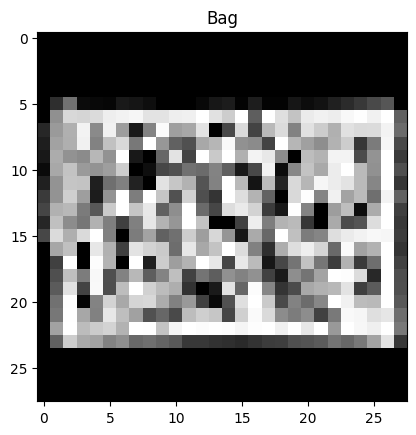

Label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Training...
Epoch 1
-------------------------------
Epoch 1 - Loss: 2.2921430  [   64/60000]
Epoch 1 - Loss: 1.9914046  [ 6464/60000]
Epoch 1 - Loss: 1.7435478  [12864/60000]
Epoch 1 - Loss: 1.6058424  [19264/60000]
Epoch 1 - Loss: 1.3179903  [25664/60000]
Epoch 1 - Loss: 1.2776364  [32064/60000]
Epoch 1 - Loss: 1.2152872  [38464/60000]
Epoch 1 - Loss: 1.0719777  [44864/60000]
Epoch 1 - Loss: 0.9900871  [51264/60000]
Epoch 1 - Loss: 1.0117038  [57664/60000]
Training Epoch 1 - Mean: 1.4459042 - Median: 1.3554630
Training Epoch 1 - Output Mean: 1.4517620 - Output Median: 1.2978133
Training finished.
Average loss: 1.4474473 -- Accuracy: 0.57997 

Train Precision: 0.60904 -- Recall: 0.57997 -- F1-Score: 0.54588

Training Average MSE: 0.0631905

Total running time of the epoch script: (0 minutes 21.566 seconds)
Testing Mean: 1.0451112 - Median: 1.0367578
Testing Error: 
Accuracy: 67.0%, Avg loss: 1.051811 

Testing Precision: 0.67794 -- Recall: 0.66980

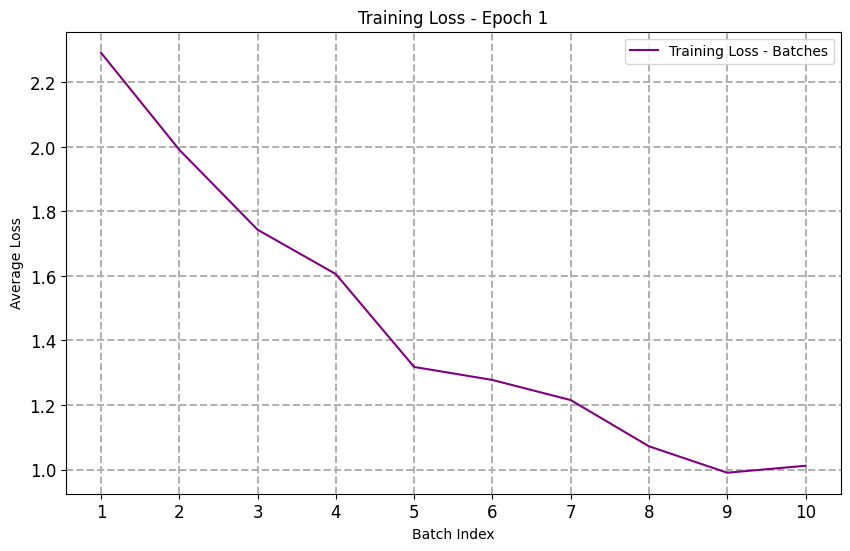

Epoch 2
-------------------------------
Epoch 2 - Loss: 0.9307770  [   64/60000]
Epoch 2 - Loss: 0.9715832  [ 6464/60000]
Epoch 2 - Loss: 0.8741044  [12864/60000]
Epoch 2 - Loss: 0.8967898  [19264/60000]
Epoch 2 - Loss: 0.9583079  [25664/60000]
Epoch 2 - Loss: 0.9730579  [32064/60000]
Epoch 2 - Loss: 0.8862111  [38464/60000]
Epoch 2 - Loss: 0.9310409  [44864/60000]
Epoch 2 - Loss: 0.8071512  [51264/60000]
Epoch 2 - Loss: 0.9226318  [57664/60000]
Training Epoch 2 - Mean: 0.9068472 - Median: 0.9043773
Training Epoch 2 - Output Mean: 0.9151655 - Output Median: 0.9267044
Training finished.
Average loss: 0.9078150 -- Accuracy: 0.71507 

Train Precision: 0.71942 -- Recall: 0.71507 -- F1-Score: 0.69956

Training Average MSE: 0.0428996

Total running time of the epoch script: (0 minutes 23.813 seconds)
Testing Mean: 0.8375126 - Median: 0.8319195
Testing Error: 
Accuracy: 72.6%, Avg loss: 0.842881 

Testing Precision: 0.72668 -- Recall: 0.72560 -- F1-Score: 0.71794

Testing Average MSE: 0.04060

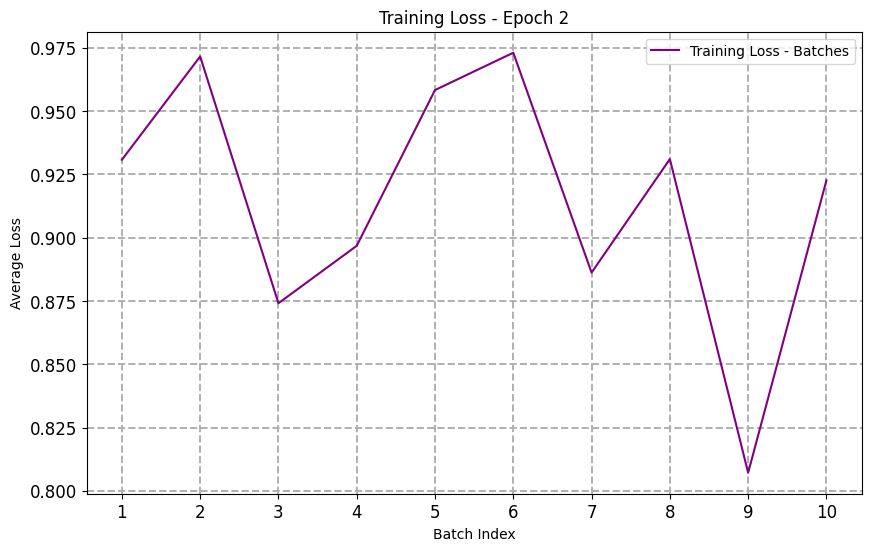

Epoch 3
-------------------------------
Epoch 3 - Loss: 0.6211334  [   64/60000]
Epoch 3 - Loss: 0.8869348  [ 6464/60000]
Epoch 3 - Loss: 0.8601441  [12864/60000]
Epoch 3 - Loss: 0.6445497  [19264/60000]
Epoch 3 - Loss: 0.6350924  [25664/60000]
Epoch 3 - Loss: 0.6771519  [32064/60000]
Epoch 3 - Loss: 0.6655205  [38464/60000]
Epoch 3 - Loss: 0.7819896  [44864/60000]
Epoch 3 - Loss: 0.8392942  [51264/60000]
Epoch 3 - Loss: 0.8110414  [57664/60000]
Training Epoch 3 - Mean: 0.7693194 - Median: 0.7654561
Training Epoch 3 - Output Mean: 0.7422852 - Output Median: 0.7295708
Training finished.
Average loss: 0.7701404 -- Accuracy: 0.75507 

Train Precision: 0.75364 -- Recall: 0.75507 -- F1-Score: 0.74828

Training Average MSE: 0.0373745

Total running time of the epoch script: (0 minutes 23.556 seconds)
Testing Mean: 0.7455869 - Median: 0.7424437
Testing Error: 
Accuracy: 75.3%, Avg loss: 0.750366 

Testing Precision: 0.75005 -- Recall: 0.75290 -- F1-Score: 0.74569

Testing Average MSE: 0.03666

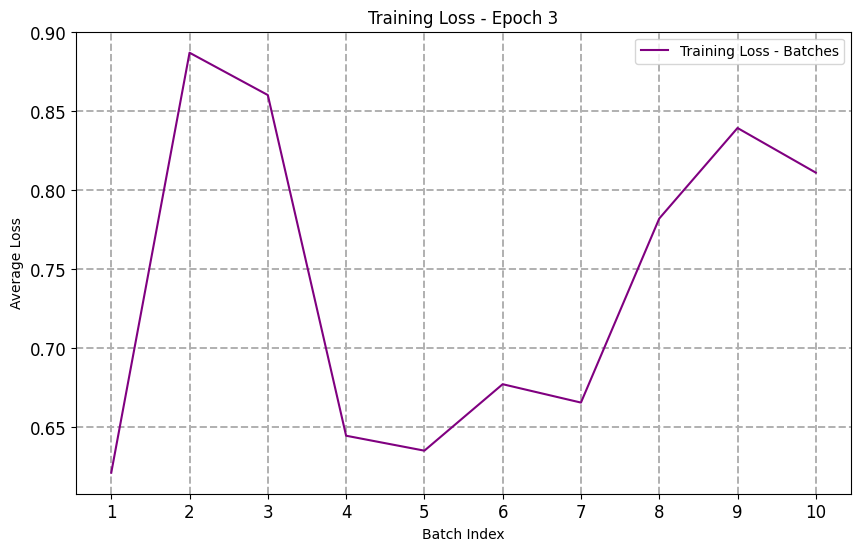

Epoch 4
-------------------------------
Epoch 4 - Loss: 0.6568125  [   64/60000]
Epoch 4 - Loss: 0.8765078  [ 6464/60000]
Epoch 4 - Loss: 0.6679387  [12864/60000]
Epoch 4 - Loss: 0.8393864  [19264/60000]
Epoch 4 - Loss: 0.5080049  [25664/60000]
Epoch 4 - Loss: 0.6028342  [32064/60000]
Epoch 4 - Loss: 0.7412603  [38464/60000]
Epoch 4 - Loss: 0.6948496  [44864/60000]
Epoch 4 - Loss: 0.6676330  [51264/60000]
Epoch 4 - Loss: 0.5612875  [57664/60000]
Training Epoch 4 - Mean: 0.6981717 - Median: 0.6941263
Training Epoch 4 - Output Mean: 0.6816515 - Output Median: 0.6677858
Training finished.
Average loss: 0.6989168 -- Accuracy: 0.77652 

Train Precision: 0.77394 -- Recall: 0.77652 -- F1-Score: 0.77156

Training Average MSE: 0.0342433

Total running time of the epoch script: (0 minutes 22.653 seconds)
Testing Mean: 0.6928766 - Median: 0.6783234
Testing Error: 
Accuracy: 76.8%, Avg loss: 0.697318 

Testing Precision: 0.76712 -- Recall: 0.76840 -- F1-Score: 0.76574

Testing Average MSE: 0.03438

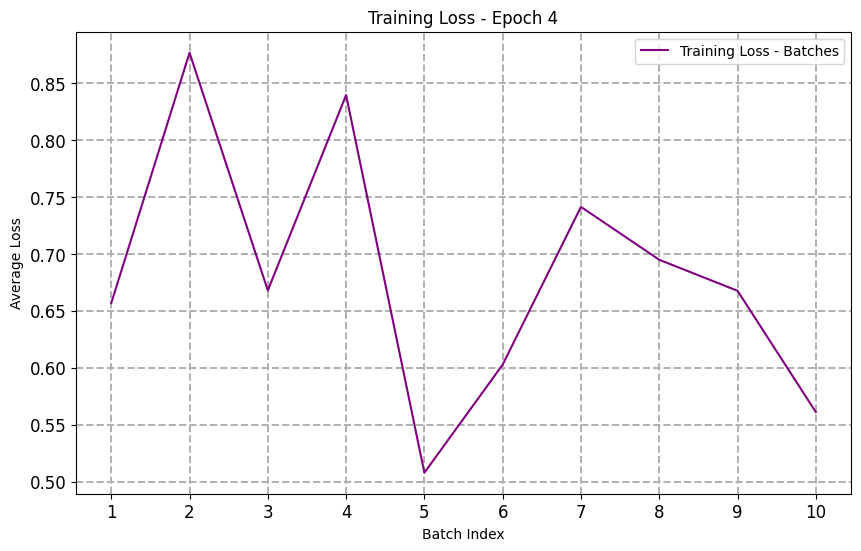

Epoch 5
-------------------------------
Epoch 5 - Loss: 0.8417555  [   64/60000]
Epoch 5 - Loss: 0.7229288  [ 6464/60000]
Epoch 5 - Loss: 0.5853917  [12864/60000]
Epoch 5 - Loss: 0.7740043  [19264/60000]
Epoch 5 - Loss: 0.7234670  [25664/60000]
Epoch 5 - Loss: 0.5441695  [32064/60000]
Epoch 5 - Loss: 0.5096422  [38464/60000]
Epoch 5 - Loss: 0.6986220  [44864/60000]
Epoch 5 - Loss: 0.6561245  [51264/60000]
Epoch 5 - Loss: 0.6062605  [57664/60000]
Training Epoch 5 - Mean: 0.6515352 - Median: 0.6424376
Training Epoch 5 - Output Mean: 0.6662366 - Output Median: 0.6773733
Training finished.
Average loss: 0.6522305 -- Accuracy: 0.79113 

Train Precision: 0.78831 -- Recall: 0.79113 -- F1-Score: 0.78726

Training Average MSE: 0.0321099

Total running time of the epoch script: (0 minutes 21.706 seconds)
Testing Mean: 0.6553078 - Median: 0.6518094
Testing Error: 
Accuracy: 77.8%, Avg loss: 0.659508 

Testing Precision: 0.77416 -- Recall: 0.77760 -- F1-Score: 0.77174

Testing Average MSE: 0.03260

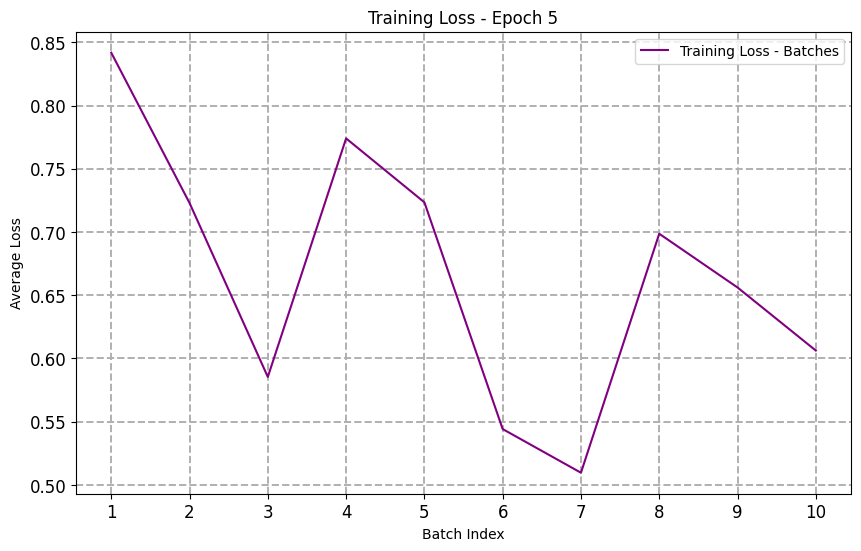

Epoch 6
-------------------------------
Epoch 6 - Loss: 0.5364252  [   64/60000]
Epoch 6 - Loss: 0.5973864  [ 6464/60000]
Epoch 6 - Loss: 0.5781963  [12864/60000]
Epoch 6 - Loss: 0.5121929  [19264/60000]
Epoch 6 - Loss: 0.4551189  [25664/60000]
Epoch 6 - Loss: 0.5001354  [32064/60000]
Epoch 6 - Loss: 0.7125288  [38464/60000]
Epoch 6 - Loss: 0.5330577  [44864/60000]
Epoch 6 - Loss: 0.7399086  [51264/60000]
Epoch 6 - Loss: 0.7256649  [57664/60000]
Training Epoch 6 - Mean: 0.6175559 - Median: 0.6111651
Training Epoch 6 - Output Mean: 0.5890615 - Output Median: 0.5573107
Training finished.
Average loss: 0.6182150 -- Accuracy: 0.79973 

Train Precision: 0.79692 -- Recall: 0.79973 -- F1-Score: 0.79638

Training Average MSE: 0.0305303

Total running time of the epoch script: (0 minutes 22.708 seconds)
Testing Mean: 0.6250517 - Median: 0.6099458
Testing Error: 
Accuracy: 78.8%, Avg loss: 0.629058 

Testing Precision: 0.78587 -- Recall: 0.78850 -- F1-Score: 0.78470

Testing Average MSE: 0.03112

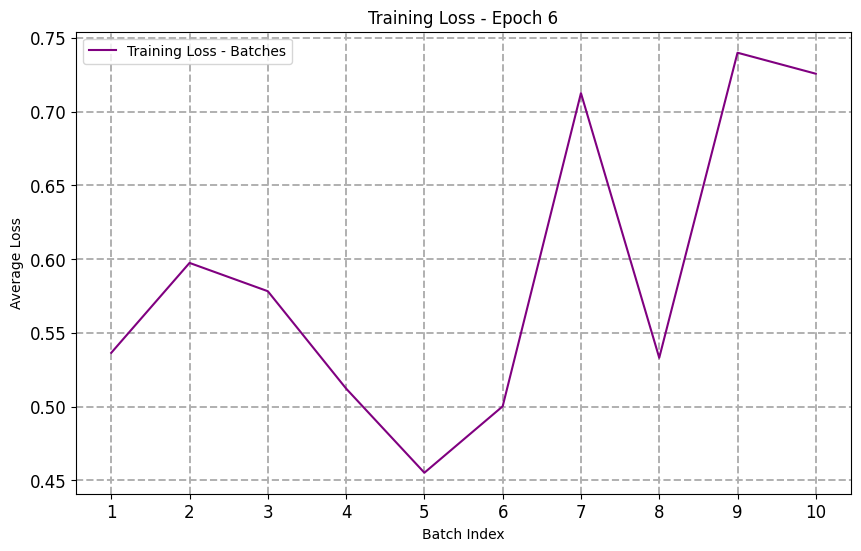

Epoch 7
-------------------------------
Epoch 7 - Loss: 0.6377234  [   64/60000]
Epoch 7 - Loss: 0.5098633  [ 6464/60000]
Epoch 7 - Loss: 0.6581343  [12864/60000]
Epoch 7 - Loss: 0.4033567  [19264/60000]
Epoch 7 - Loss: 0.6158711  [25664/60000]
Epoch 7 - Loss: 0.4266176  [32064/60000]
Epoch 7 - Loss: 0.5604290  [38464/60000]
Epoch 7 - Loss: 0.6187884  [44864/60000]
Epoch 7 - Loss: 0.5208658  [51264/60000]
Epoch 7 - Loss: 0.4606628  [57664/60000]
Training Epoch 7 - Mean: 0.5911535 - Median: 0.5861363
Training Epoch 7 - Output Mean: 0.5412312 - Output Median: 0.5406474
Training finished.
Average loss: 0.5917844 -- Accuracy: 0.80728 

Train Precision: 0.80474 -- Recall: 0.80728 -- F1-Score: 0.80441

Training Average MSE: 0.0292893

Total running time of the epoch script: (0 minutes 23.111 seconds)
Testing Mean: 0.6037255 - Median: 0.6004520
Testing Error: 
Accuracy: 79.6%, Avg loss: 0.607596 

Testing Precision: 0.79254 -- Recall: 0.79600 -- F1-Score: 0.79305

Testing Average MSE: 0.03017

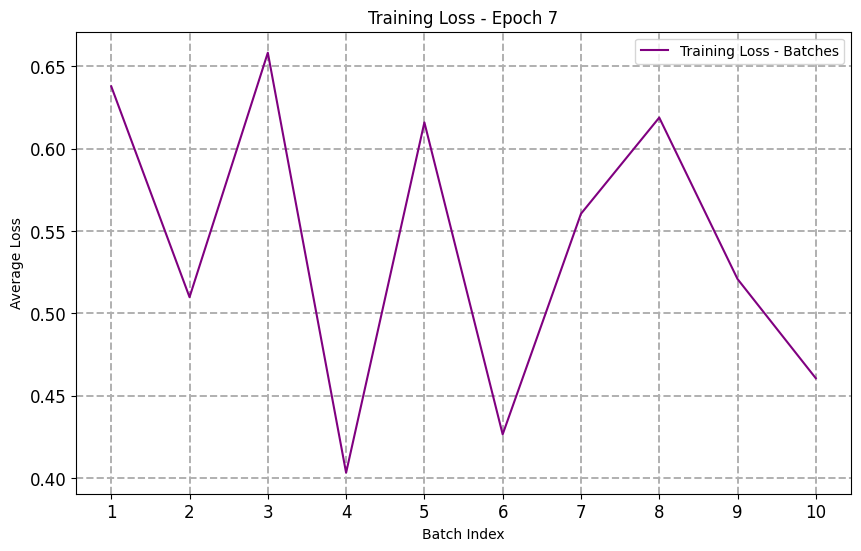

Epoch 8
-------------------------------
Epoch 8 - Loss: 0.5913356  [   64/60000]
Epoch 8 - Loss: 0.5483648  [ 6464/60000]
Epoch 8 - Loss: 0.5006554  [12864/60000]
Epoch 8 - Loss: 0.5120542  [19264/60000]
Epoch 8 - Loss: 0.5303915  [25664/60000]
Epoch 8 - Loss: 0.6268078  [32064/60000]
Epoch 8 - Loss: 0.6428449  [38464/60000]
Epoch 8 - Loss: 0.6354152  [44864/60000]
Epoch 8 - Loss: 0.6386709  [51264/60000]
Epoch 8 - Loss: 0.7476851  [57664/60000]
Training Epoch 8 - Mean: 0.5700699 - Median: 0.5675388
Training Epoch 8 - Output Mean: 0.5974226 - Output Median: 0.6090717
Training finished.
Average loss: 0.5706783 -- Accuracy: 0.81335 

Train Precision: 0.81077 -- Recall: 0.81335 -- F1-Score: 0.81065

Training Average MSE: 0.0282934

Total running time of the epoch script: (0 minutes 23.864 seconds)
Testing Mean: 0.5857504 - Median: 0.5886175
Testing Error: 
Accuracy: 80.3%, Avg loss: 0.589505 

Testing Precision: 0.80096 -- Recall: 0.80300 -- F1-Score: 0.80132

Testing Average MSE: 0.02933

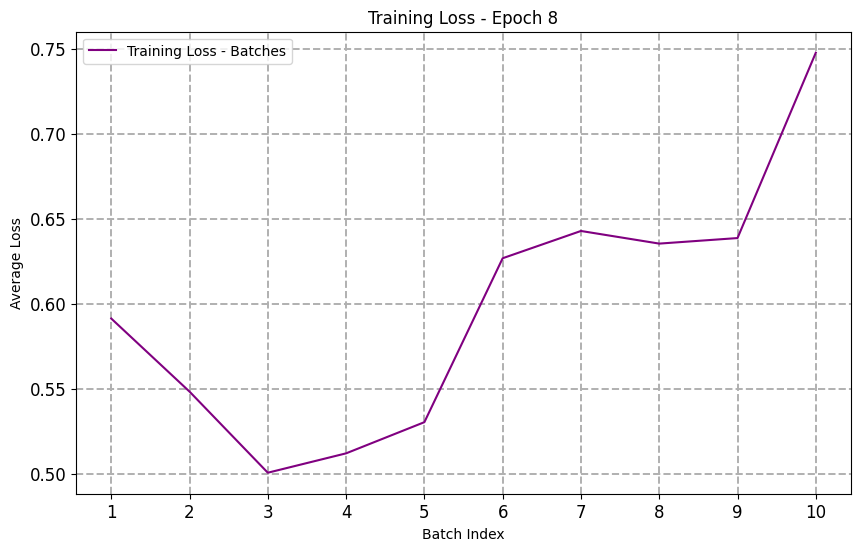

Epoch 9
-------------------------------
Epoch 9 - Loss: 0.6032846  [   64/60000]
Epoch 9 - Loss: 0.6142558  [ 6464/60000]
Epoch 9 - Loss: 0.3943050  [12864/60000]
Epoch 9 - Loss: 0.5196802  [19264/60000]
Epoch 9 - Loss: 0.5604043  [25664/60000]
Epoch 9 - Loss: 0.5091405  [32064/60000]
Epoch 9 - Loss: 0.5906539  [38464/60000]
Epoch 9 - Loss: 0.5707908  [44864/60000]
Epoch 9 - Loss: 0.5700068  [51264/60000]
Epoch 9 - Loss: 0.5531216  [57664/60000]
Training Epoch 9 - Mean: 0.5528037 - Median: 0.5418075
Training Epoch 9 - Output Mean: 0.5485643 - Output Median: 0.5652056
Training finished.
Average loss: 0.5533937 -- Accuracy: 0.81777 

Train Precision: 0.81537 -- Recall: 0.81777 -- F1-Score: 0.81527

Training Average MSE: 0.0274837

Total running time of the epoch script: (0 minutes 22.248 seconds)
Testing Mean: 0.5696258 - Median: 0.5723381
Testing Error: 
Accuracy: 80.5%, Avg loss: 0.573277 

Testing Precision: 0.80314 -- Recall: 0.80510 -- F1-Score: 0.80252

Testing Average MSE: 0.02857

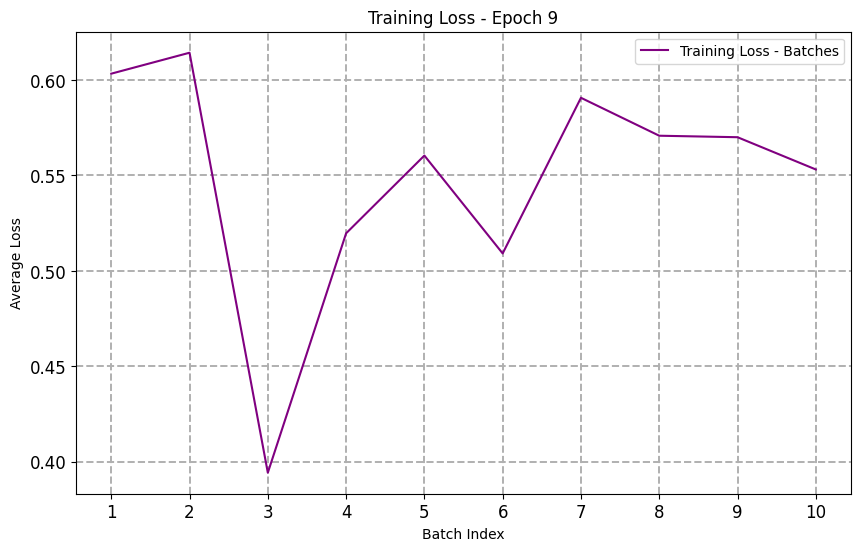

Epoch 10
-------------------------------
Epoch 10 - Loss: 0.5509582  [   64/60000]
Epoch 10 - Loss: 0.6310596  [ 6464/60000]
Epoch 10 - Loss: 0.4881009  [12864/60000]
Epoch 10 - Loss: 0.7120490  [19264/60000]
Epoch 10 - Loss: 0.4772169  [25664/60000]
Epoch 10 - Loss: 0.4687259  [32064/60000]
Epoch 10 - Loss: 0.6166845  [38464/60000]
Epoch 10 - Loss: 0.6600221  [44864/60000]
Epoch 10 - Loss: 0.6126396  [51264/60000]
Epoch 10 - Loss: 0.6166805  [57664/60000]
Training Epoch 10 - Mean: 0.5385894 - Median: 0.5325322
Training Epoch 10 - Output Mean: 0.5834137 - Output Median: 0.6146600
Training finished.
Average loss: 0.5391643 -- Accuracy: 0.82173 

Train Precision: 0.81960 -- Recall: 0.82173 -- F1-Score: 0.81953

Training Average MSE: 0.0268239

Total running time of the epoch script: (0 minutes 21.564 seconds)
Testing Mean: 0.5579327 - Median: 0.5483779
Testing Error: 
Accuracy: 81.1%, Avg loss: 0.561509 

Testing Precision: 0.80717 -- Recall: 0.81070 -- F1-Score: 0.80726

Testing Average

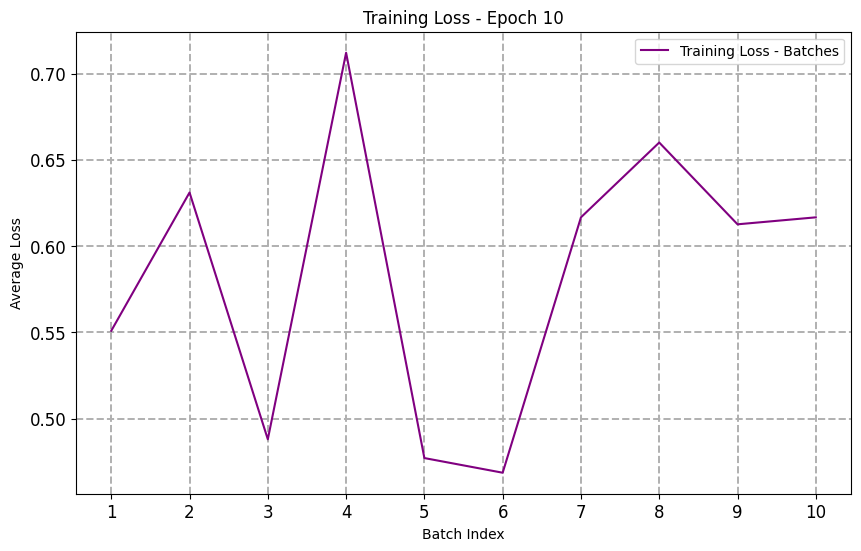

Done!
Saved NumPy Model State to numpy_model.pkl
Loaded NumPy Model State from numpy_model.pkl
Длина labels_map: 10
Predicted: Trouser, Actual: Trouser


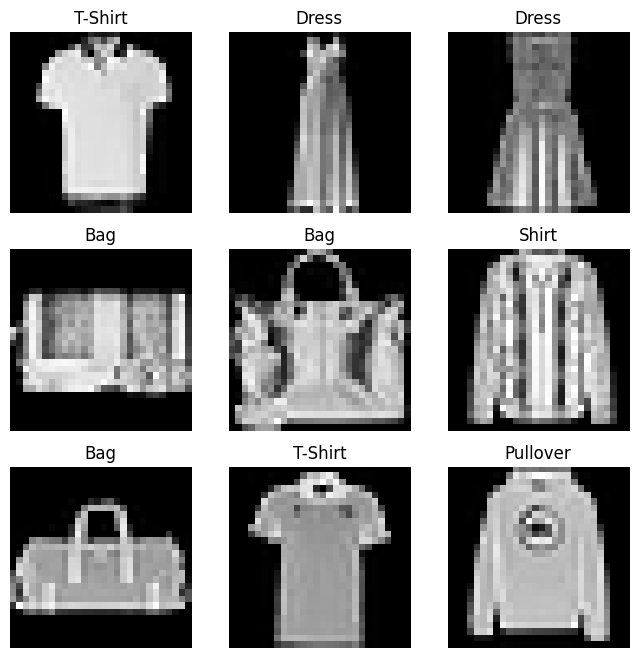

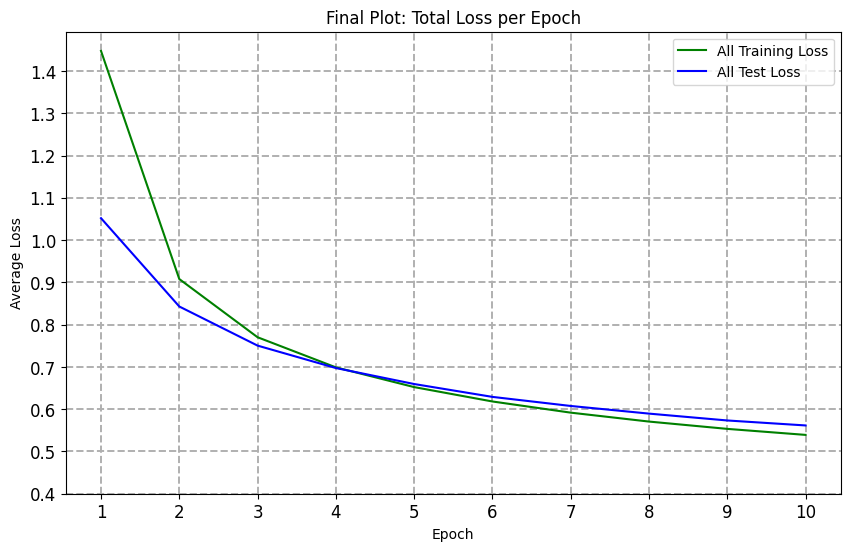

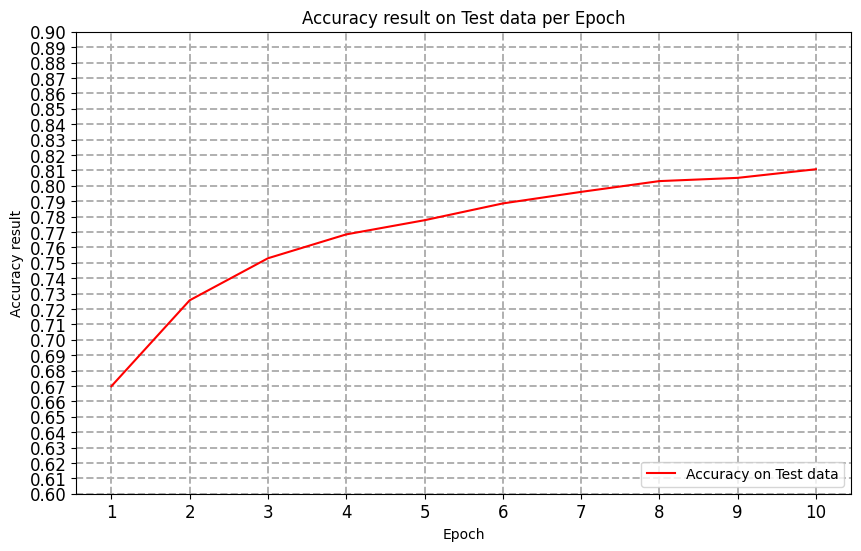

Total running time of the script: (4 minutes 15.325 seconds)
Script started at: 2025-03-17 14:53:15
Script ended at: 2025-03-17 14:57:31
time.struct_time(tm_year=2025, tm_mon=3, tm_mday=17, tm_hour=14, tm_min=57, tm_sec=31, tm_wday=0, tm_yday=76, tm_isdst=0)


In [11]:
# Импортируемые библиотеки
import numpy as np
import pandas as pd
from torchvision import datasets
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import pickle
from dataclasses import dataclass, field
from typing import Optional
import time
import statistics
import random
import warnings; warnings.filterwarnings(action='once')

# Инициализация глобальных параметров
@dataclass(frozen=True)
class Constants:
    input_size: int = 28 * 28
    segment_size: int = 28
    hidden_size: int = 512
    output_size: int = 10
    learning_rate: float = 1e-3
    tolerance: float = 1e-15
    epochs: int = 10
    batch_size: int = 64
    report_interval: int = 100
    num_images: int = 9
    num_classes: int = 10
    pixel_value: float = 255.0
    filename: Optional[str] = field(default=None, init=False)

    def __post_init__(self):
        object.__setattr__(self, 'filename', "numpy_model.pkl")

MY_CONSTANTS = Constants()

# Загружаем массив подписей
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

"""
[EN] Function that loads FashionMNIST dataset and preprocesses it for NumPy-based Neural Network.
[RU] Функция, которая загружает FashionMNIST датасет и подготавливает его для NumPy-based Neural Network
"""
def load_fashion_mnist(train=True,
                       flatten=True,
                       normalize=True):
    try:
        data = datasets.FashionMNIST(root="data", train=train, download=True)
    except Exception as e:
        print(f"Error loading FashionMNIST: {e}")
        return None, None
    num_samples = len(data)
    img_shape = data[0][0].size
    if flatten:
        img_size = img_shape[0] * img_shape[1]
        images = np.zeros((num_samples, img_size), dtype=np.float32)
    else:
        images = np.zeros((num_samples, img_shape[0], img_shape[1]), dtype=np.float32)
    labels = np.zeros(num_samples, dtype=np.int64)

    for idx, (img, label) in enumerate(data):

        # Converting to float32
        img_np = np.array(img, dtype=np.float32)
        if normalize:

            # Normalize pixel values
            img_np /= MY_CONSTANTS.pixel_value
        if flatten:
            img_np = img_np.flatten()

        images[idx] = img_np
        labels[idx] = label

    return images, labels

"""
[EN] Function that display a grid of random images from the dataset.
[RU] Функция для вывода графика рандомных изображений из  датасета
"""
def display_random_images(images,
                          labels,
                          labels_map,
                          num_images=MY_CONSTANTS.num_images):
      figure = plt.figure(figsize=(8, 8))
      cols, rows = 3, 3
      for i in range(1, num_images + 1):
          sample_idx = np.random.randint(0, len(images))
          img = images[sample_idx]
          label = labels[sample_idx]
          figure.add_subplot(rows, cols, i)
          plt.title(labels_map[label])
          plt.axis("off")
          plt.imshow(img.reshape(MY_CONSTANTS.segment_size,
                                 MY_CONSTANTS.segment_size),
                     cmap="gray")
      plt.show()

"""
[EN] Function that prints a cycle graph.
[RU] Функция для вывода графика-тренировки в цикле
"""
def print_cycle_graph(batch_indices,
                      batch_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(batch_indices, batch_losses, label="Training Loss - Batches", color="purple")
    plt.xlabel("Batch Index")
    plt.ylabel("Average Loss")
    plt.title(f"Training Loss - Epoch {epoch_count}")
    plt.grid(True, linestyle='--', linewidth = "1.4")
    plt.yticks(fontsize=12)
    plt.xticks(range(1, 11), fontsize=12)
    plt.legend(["Training Loss - Batches"])
    plt.show()

"""
[EN] Function that returns a loss-function graph.
[RU] Функция для вывода графика функции потерь
"""
def print_result_graph(avg_loss_train,
                       avg_loss_test):
  epochs = range(1, len(avg_loss_train) + 1)
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, avg_loss_train, label="All Training Loss", color='green') # Plot all train losses
  plt.plot(epochs, avg_loss_test, label="All Test Loss", color='blue') # Plot all test losses
  plt.xlabel("Epoch")
  plt.ylabel("Average Loss")
  plt.title("Final Plot: Total Loss per Epoch")
  plt.grid(True, linestyle='--', linewidth = "1.4")
  plt.xticks(range(1, 11), fontsize=12)
  plt.yticks(np.arange(0.4, 1.5, 0.1), fontsize=12)
  plt.legend()
  plt.show()

"""
[EN] Function that returns a test-accuracy graph.
[RU] Функция для вывода графика точности на тесте
"""
def print_accuracy_graph(accuracy_test):
  epochs = range(1, len(avg_loss_train) + 1)
  plt.figure(figsize=(10,6))
  plt.plot(epochs, accuracy_test, color="red", label="Accuracy on Test data") # Plot test accuracy
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy result")
  plt.title("Accuracy result on Test data per Epoch")
  plt.grid(True, linestyle='--', linewidth='1.4')
  plt.xticks(range(1, 11), fontsize=12)
  plt.yticks(np.arange(0.6, 0.9, 0.01), fontsize=12)
  plt.legend(loc='lower right')
  plt.show()

"""
[EN] Function that creates batches of data from NumPy arrays.
[RU] Функция для создания серий из данных на основе массивов NumPy
"""
def create_batches(images,
                   labels,
                   batch_size=MY_CONSTANTS.batch_size,
                   shuffle=True,
                   reshape=True):
    num_samples = images.shape[0]
    if shuffle:
        permutation = np.random.permutation(num_samples)
        images = images[permutation]
        labels = labels[permutation]
    for i in range(0, num_samples, batch_size):
        batch_images = images[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        if reshape:
             batch_images = batch_images.reshape(-1,
                                                 MY_CONSTANTS.segment_size,
                                                 MY_CONSTANTS.segment_size)
             batch_images = np.expand_dims(batch_images, axis=1)
        yield batch_images, batch_labels

"""
[EN] Function that encodes the labels.
[RU] Функция для кодирования подписей
"""
def label_encode(labels,
                 num_classes=MY_CONSTANTS.num_classes):
    encoded_labels = np.zeros((len(labels), num_classes), dtype=np.float32)
    encoded_labels[np.arange(len(labels)), labels] = 1
    return encoded_labels

# Выставляем стартовое время работы алгоритма
start_time = time.time()

# Загружаем тренировочный датасет
train_images, train_labels = load_fashion_mnist(train=True,
                                                flatten=True,
                                                normalize=True)
# Загружаем тестовый датасет
test_images, test_labels = load_fashion_mnist(train=False,
                                              flatten=True,
                                              normalize=True)

# Выводим данные датасетов - размер, тип и длину
print(f"Train images shape: {train_images.shape}, type: {train_images.dtype}, images_len: {len(train_images)}")
print(f"Train labels shape: {train_labels.shape}, type: {train_labels.dtype}, labels_len: {len(train_labels)}")
print(f"Test images shape: {test_images.shape}, type: {test_images.dtype}, images_len: {len(test_images)}")
print(f"Test labels shape: {test_images.shape}, type: {test_images.dtype}, labels_len: {len(test_images)}")

# Using pandas DataFrame function to take information about dataset
# Пробуем узнать более подробную информацию о датасете с помощью pandas DataFrame
train_images_df = pd.DataFrame(train_images)
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_images_df = pd.DataFrame(test_images)
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

print("Description of training images:")
print(train_images_df.describe())
print("Taking an info of training images:")
print(train_images_df.info())

print("\nDescription of training labels:")
print(train_labels_df.describe())
print("Taking an info of training labels:")
print(train_labels_df.info())

print("\nDescription of test images:")
print(test_images_df.describe())
print("Taking an info of test images:")
print(test_images_df.info())

print("\nDescription of test labels:")
print(test_labels_df.describe())
print("Taking an info of test labels:")
print(test_labels_df.info())

# Implemeting Numpy Neural Network as class
# Имплементация класса Numpy Neural Network

# Класс Linear - функция для применения аффинного линейного пространства к входящим данным: y=xA^T+b
class Linear:
    def __init__(self, in_features,
                 out_features):
        """
        [EN] Initializes the weights for NumPy-based neural network.
        [RU] Инициализация весов для NumPy-based neural network
        """
        k = 2.0 / in_features
        # Веса
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(k)

        # Смещения
        self.bias = np.zeros((1, out_features))

    # Прямой ход класса Linear
    def forward(self,
                x):
        self.input = x
        return np.dot(x, self.weights) + self.bias

    # Обратный ход класса Linear
    def backward(self,
                 grad_output):

        # Градиент по весам
        grad_weights = np.dot(self.input.T, grad_output)

        # Градиент по смещению
        grad_bias = np.sum(grad_output, axis=0, keepdims=True)

        # Градиент по входу
        grad_input = np.dot(grad_output, self.weights.T)
        return grad_weights, grad_bias, grad_input

# Класс ReLU - функция выпрямленных линейных единиц измерения
# ReLU(x)=(x) += max(0,x)
class ReLU:
    """
    [EN] Forward step for ReLU activation function.
    [RU] Прямой ход для активационной ReLU функции
    """
    def forward(self,
                x):
        self.input = x
        return np.maximum(0, x)

    """
    [EN] Backward step for ReLU activation function.
    [RU] Обратный ход для активационной ReLU функции
    """
    def backward(self,
                 grad_output):
        return grad_output * (self.input > 0).astype(float)

# Класс NumpyNeuralNetwork - основной класс реализации нейронной сети на numpy
class NumpyNeuralNetwork:
    def __init__(self,
                 input_size=MY_CONSTANTS.input_size,
                 hidden_size=MY_CONSTANTS.hidden_size,
                 output_size=MY_CONSTANTS.output_size,
                 learning_rate=MY_CONSTANTS.learning_rate):
        """
        Инициализация нейронной сети с тремя скрытыми слоями
        """
        self.learning_rate = learning_rate

        # Создаем последовательность слоев
        self.layers = [
            Linear(input_size, hidden_size),  # Первый линейный слой
            ReLU(), # Первое использование ReLU
            Linear(hidden_size, hidden_size), # Второй линейный слой
            ReLU(), # Второе использование ReLU
            Linear(hidden_size, output_size)  # Выходной слой
        ]
    """
    [EN] Softmax function for output layer.
    softmax(x)i = exp(x_i - max(x)) / sum{j=1}^{K} exp(x_j - max(x))
    [RU] Использование функции SoftMax
    """
    def softmax(self,
                x):
        maxx = np.exp(x - np.max(x, axis=1, keepdims=True))
        return maxx / np.sum(maxx, axis=1, keepdims=True)

    """
    [EN] Cross-entropy loss function.
    Using categorical cross entropy function:
    -1/N * sum({j=1}^{N} ; log(predicted[y_i]))
    [RU] Функция cross-энтропии для потерь
    """
    def cross_entropy_loss(self,
                           predicted,
                           target):
        predicted = np.clip(predicted, MY_CONSTANTS.tolerance, 1 - MY_CONSTANTS.tolerance)
        sample_num = target.shape[0]
        log_likelihood = -np.log(predicted[range(sample_num), target])
        loss = np.sum(log_likelihood) / sample_num
        return loss

    """
    [EN] Forward pass through the network.
    [RU] Прямой ход созданной нейронной сети
    """
    def forward(self,
                input_data):
        x = input_data
        activations = [x]

        # Проход через все слои
        for layer in self.layers:
            x = layer.forward(x)
            activations.append(x)

        output = self.softmax(x)
        return output, activations

    """
    [EN] Backward pass for backpropagation.
    [RU] Обратный ход созданной нейронной сетим
    """
    def backward(self,
                 input_data,
                 target,
                 output,
                 activations):
        sample_num = input_data.shape[0]
        gradients = []

        # Начальный градиент от ошибки
        # Вычисляет начальную ошибку, которая затем используется для корректировки весов сети и улучшения ее способности делать точные прогнозы. Этот пример подходит для MSE и для перекрестной энтропии с сигмоидой, когда выход находится между 0 и 1.
        # Квадратичная ошибка (Mean Squared Error - MSE): Loss = 0.5 * (output - target)^2  output_error = output - target
        # Перекрестная энтропия (Cross-Entropy Loss): Используется для задач классификации. Формула немного сложнее, но для сигмоидной функции активации в выходном слое: output_error = output - target
        output_error = output - target

        # Обратное распространение через слои
        grad = output_error
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]

            # isinstance в Python - это встроенная функция (built-in function), а не метод объекта. Она используется для проверки, принадлежит ли объект указанному типу или классу (или одному из типов/классов в кортеже).
            if isinstance(layer, Linear):
                grad_weights, grad_bias, grad_input = layer.backward(grad)

                # Добавляем градиенты
                gradients.append({
                    "weights": grad_weights / sample_num,
                    "bias": grad_bias / sample_num
                })
                grad = grad_input
            else:  # ReLU
                grad = layer.backward(grad)

        return list(reversed(gradients))  # Разворачиваем градиенты в правильном порядке

    """
    [EN] Applies the calculated gradients to update weights and biases.
    [RU] Обновление вычисленных градиентов для обновления весов и сдвигов
    """
    def apply_gradients(self,
                        gradients):
        linear_idx = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                layer.weights -= self.learning_rate * gradients[linear_idx]["weights"]
                layer.bias -= self.learning_rate * gradients[linear_idx]["bias"]
                linear_idx += 1

    """
    [EN] Training fuction of the neural network based on batch gradient descent.
    [RU] Тренировочная функция нейронной сети, основанная на методе градиентного спуска
    """
    def train(self,
              count,
              train_images,
              train_labels,
              num_batches,
              epochs=MY_CONSTANTS.epochs,
              batch_size=MY_CONSTANTS.batch_size,
              report_interval=MY_CONSTANTS.report_interval):

        points_per_epoch = MY_CONSTANTS.num_classes
        train_batches = create_batches(train_images, train_labels, batch_size, reshape=False)
        num_samples = train_images.shape[0]
        sampled_indices = list(range(1, points_per_epoch + 1))
        sample_step = num_batches / points_per_epoch
        sampled_losses = []

        for epoch in range(epochs):
            total_loss = 0.0
            correct_predictions = 0
            batch_losses = []
            batch_indices = []
            all_predictions = []  # Список для всех предсказаний
            all_labels = []      # Список для всех истинных меток
            output_batch_losses = []
            total_mse = 0.0      # Накопление MSE по эпохе
            mse_batch_values = []  # Список MSE для каждого батча

            # Засекаем время обработки данных на каждой эпохе
            start_epoch_time = time.time()
            for batch_idx, (batch_images, batch_labels) in enumerate(train_batches):

                # Получение закодированных подписей
                batch_labels = batch_labels.astype(np.int64)
                batch_encoded_labels = label_encode(batch_labels)

                # Прямой ход
                output, activations = self.forward(batch_images)

                # Обратный ход
                gradients = self.backward(batch_images, batch_encoded_labels, output, activations)
                self.apply_gradients(gradients)

                # Calculate metrics (loss for reporting)
                # Подсчёт метрики
                loss = self.cross_entropy_loss(output, batch_labels)
                total_loss += loss
                batch_losses.append(loss)
                batch_indices.append(batch_idx)
                predictions = np.argmax(output, axis=1) # Get predictions from forward pass
                correct_predictions += np.sum(predictions == batch_labels) # Count number of examples correctly predicted
                all_predictions.extend(predictions)  # Добавляем предсказания батча
                all_labels.extend(batch_labels)      # Добавляем истинные метки батча

                # Расчёт MSE для батча
                mse = np.mean(np.square(output - batch_encoded_labels))
                total_mse += mse
                mse_batch_values.append(mse)

                if batch_idx % report_interval == 0:
                    current = batch_idx * batch_size + len(batch_images)

                    # Вывод информации об эпохе и результате функции потерь
                    print(f"Epoch {count} - Loss: {loss:.7f}  [{current:>5d}/{num_samples:>5d}]")
                    output_batch_losses.append(loss)
                    if len(sampled_losses) < points_per_epoch:
                        sampled_losses.append(loss)

            while len(sampled_losses) < points_per_epoch:
                sampled_losses.append(loss)

            # Подсчёт среднего и медианы для функции потерь
            median_loss = np.median(batch_losses)
            mean_loss = np.mean(batch_losses)
            median_output_loss = np.median(output_batch_losses)
            mean_output_loss = np.mean(output_batch_losses)

            # Calculating average loss and accuracy after each epoch
            # Подсчёт общей потери и точности после каждой эпохи
            avg_loss = total_loss / num_batches
            avg_accuracy = correct_predictions / num_samples

             # Подсчёт средней MSE по эпохе
            avg_mse = total_mse / num_batches

            # Подсчёт метрики: precision, recall, f1
            precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
            recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
            f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
            print(f"Training Epoch {count} - Mean: {mean_loss:.7f} - Median: {median_loss:.7f}")
            print(f"Training Epoch {count} - Output Mean: {mean_output_loss:.7f} - Output Median: {median_output_loss:.7f}")
            print(f"Training finished.\nAverage loss: {avg_loss:.7f} -- Accuracy: {avg_accuracy:.5f} \n")
            print(f"Train Precision: {precision:.5f} -- Recall: {recall:.5f} -- F1-Score: {f1:.5f}\n")
            print(f"Training Average MSE: {avg_mse:.7f}\n")

            # Засекаем время окончания обработки данных на каждой эпохе
            end_epoch_time = time.time()
            total_epoch_time = end_epoch_time - start_epoch_time
            minutes = int(total_epoch_time // 60)
            seconds = total_epoch_time % 60

            # Вывод общего времени на одной эпохе
            print(f"Total running time of the epoch script: ({minutes} minutes {seconds:.3f} seconds)")
            self.batch_losses = sampled_losses
            self.train_loss = avg_loss
            self.batch_indices = sampled_indices
            return avg_loss

    """
    [EN] The implemention of test (predict) function.
    [RU] Имплементация функции-теста для нейронной сети
    """
    def predict(self,
                test_images,
                test_labels,
                batch_size=MY_CONSTANTS.batch_size):

        test_batches = create_batches(test_images, test_labels, batch_size, reshape=False)
        num_samples = test_images.shape[0]
        num_batches = num_samples // batch_size

        total_loss = 0.0
        correct_predictions = 0
        batch_losses = []
        all_predictions = []  # Список для всех предсказаний
        all_labels = []      # Список для всех истинных меток
        total_mse = 0.0      # Накопление MSE по эпохе
        mse_batch_values = []  # Список MSE для каждого батча

        for batch_images, batch_labels in test_batches:
            batch_labels = batch_labels.astype(np.int64)
            batch_encoded_labels = label_encode(batch_labels)

            # Прямой ход
            output, _ = self.forward(batch_images)

            # Calculating Loss
            # Подсчёт функции потерь
            loss = self.cross_entropy_loss(output, batch_labels)
            total_loss += loss
            batch_losses.append(loss)
            predictions = np.argmax(output, axis=1) # Getting the predictions
            correct_predictions += np.sum(predictions == batch_labels) # Summing the correct predictions
            all_predictions.extend(predictions)  # Добавляем предсказания батча
            all_labels.extend(batch_labels)      # Добавляем истинные метки батча

            # Расчёт MSE для батча
            mse = np.mean(np.square(output - batch_encoded_labels))
            total_mse += mse
            mse_batch_values.append(mse)

        # Подсчёт среднего и медианы для функции потерь
        median_loss = np.median(batch_losses)
        mean_loss = np.mean(batch_losses)

        # Подсчёт общей потери и точности
        avg_loss = total_loss / num_batches
        accuracy = correct_predictions / num_samples

        # Подсчёт средней MSE по эпохе
        avg_mse = total_mse / num_batches

        # Подсчёт метрики: precision, recall, f1
        precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

        # Вывод подсчитанных результатов
        print(f"Testing Mean: {mean_loss:.7f} - Median: {median_loss:.7f}")
        print(f"Testing Error: \nAccuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")
        print(f"Testing Precision: {precision:.5f} -- Recall: {recall:.5f} -- F1-Score: {f1:.5f}\n")
        print(f"Testing Average MSE: {avg_mse:.7f}\n")
        self.test_loss = avg_loss
        return accuracy, avg_loss, batch_losses

    """
    [EN] Saves the model weights to a file using pickle library.
    [RU] Сохранение весов модели в файл с использованием библиотеки pickle
    """
    def save_model(self,
                   filename=MY_CONSTANTS.filename):
        weights = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                weights[f"layer_{i}_weights"] = layer.weights
                weights[f"layer_{i}_bias"] = layer.bias
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)
        print(f"Saved NumPy Model State to {filename}")

    """
    [EN] Loads the model weights from a file.
    [RU] Загрузка весов модели из файла
    """
    def load_model(self,
                   filename=MY_CONSTANTS.filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)
        linear_idx = 0
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                layer.weights = weights[f"layer_{i}_weights"]
                layer.bias = weights[f"layer_{i}_bias"]
                linear_idx += 1
        print(f"Loaded NumPy Model State from {filename}")

    """
    [EN] Function that help us to make a prediction by index
    [RU] Функция-предсказания для элемента по его индексу
    """
    def single_test(self,
                    index,
                    test_images,
                    test_labels):
        image = test_images[index].reshape(1, -1)
        label = test_labels[index]

        # Прямой ход
        output, _ = self.forward(image)
        predicted_label = labels_map[np.argmax(output)]
        print(f"Predicted: {predicted_label}, Actual: {labels_map[label]}")

# Using CPU device (CUDA IS ANVAILABLE)
# Используем центральный процессор (CPU)
device = "cpu"
print("Using CPU device")
print(f"Using {device} device")

# Create the model
# Создание модели
numpy_model = NumpyNeuralNetwork(MY_CONSTANTS.input_size,
                                 MY_CONSTANTS.hidden_size,
                                 MY_CONSTANTS.output_size,
                                 MY_CONSTANTS.learning_rate)

# Collecting train dataset
# Сборка тренировочного датасета
train_batches = create_batches(train_images,
                               train_labels,
                               batch_size=MY_CONSTANTS.batch_size)
# Collecting test dataset
# Сборка тестового датасета
test_batches = create_batches(test_images,
                              test_labels,
                              batch_size=MY_CONSTANTS.batch_size)

# Printing shapes of X and y from test_batches
# Вывод информации о тестовой сборке
for X, y in test_batches:
    print(f"Shape of X [N, C, H, W]: {X.shape}, type X: {X.dtype}")
    print(f"Shape of y: ([{y.shape[0]}]) {y.dtype}")
    break

# Printing train images and labels information
# Вывод информации о тренировочных картинках и подписях
train_features, train_labels1 = next(iter(train_batches))
train_labels_one_hot = label_encode(train_labels1)

print(f"Feature batch shape: {train_features.shape}, Feature type: {train_features.dtype}")
print(f"Labels batch shape: {train_labels_one_hot.shape}, Labels type: {train_labels_one_hot.dtype}")

# --- Displaying the Image ---
# Визуализация картинки из тренировочного датасета
img = train_features[0].squeeze()  # Squeeze removes the channel dimension (now (28, 28))
label = train_labels1[0]
plt.imshow(img, cmap="gray")
plt.title(labels_map[label])
plt.show()
print(f"Label: {train_labels_one_hot[0]}")

num_samples = train_images.shape[0]
num_batches = num_samples // MY_CONSTANTS.batch_size

# Инициализация массивов для построения графика
avg_loss_train = []
all_train_losses1 = []
avg_loss_test = []
accuracy_test = []

# Training the model and predicing the result
# Тренировка модели и предсказание результата
print("Training...")
for index in range(MY_CONSTANTS.epochs):
    epoch_count = index + 1
    print(f"Epoch {epoch_count}\n-------------------------------")
    avg_loss1 = numpy_model.train(epoch_count,
                      train_images,
                      train_labels,
                      num_batches,
                      1,
                      MY_CONSTANTS.batch_size,
                      MY_CONSTANTS.report_interval)

    # Общяя тренировочная потеря
    avg_loss_train.append(avg_loss1)
    accuracy, avg_loss, test_losses = numpy_model.predict(test_images,
                                             test_labels,
                                             batch_size=MY_CONSTANTS.batch_size)
    # Общяя тестовая потеря и точность
    avg_loss_test.append(avg_loss)
    accuracy_test.append(accuracy)

    # Вывод тренировочного графика для каждой итерации
    print(f"Test Accuracy: {accuracy:.4f}, Test Average Loss: {avg_loss:.4f}")
    print_cycle_graph(numpy_model.batch_indices,
                      numpy_model.batch_losses)
    numpy_model.batch_losses = []
print("Done!")

# Saving model before it's export
# Сохранение модели перед её экспортом
numpy_model.save_model(MY_CONSTANTS.filename)

# Loading saved model
# Загрузка сохранённой модели
loaded_model = NumpyNeuralNetwork(MY_CONSTANTS.input_size,
                                  MY_CONSTANTS.hidden_size,
                                  MY_CONSTANTS.output_size,
                                  MY_CONSTANTS.learning_rate)
loaded_model.load_model(MY_CONSTANTS.filename)

# Making a prediction using index value
# Выполнение предсказания на основе рандомного индекса
length = len(labels_map)
if length is not None:
  print(f"Длина labels_map: {length}")
else:
  print("Ошибка: Переданный объект не является массивом/словарем.")
index = random.randint(0, len(labels_map) - 1)
numpy_model.single_test(index, test_images, test_labels)

# Displaying images from train dataset
# Визуализация изображений из тренировочного датасета
display_random_images(train_images, train_labels, labels_map)

# Вывод графика-результата сравнения функции потерь на тренировочных и тестовых данных
print_result_graph(avg_loss_train, avg_loss_test)

# Вывод графика точности на тестовых данных
print_accuracy_graph(accuracy_test)

# Расчёт и вывод времени окончания работы программы разными способами
end_time = time.time()
total_time = end_time - start_time
minutes = int(total_time // 60)
seconds = total_time % 60
print(f"Total running time of the script: ({minutes} minutes {seconds:.3f} seconds)")

start_time_formatted = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time))
end_time_formatted = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time))

print(f"Script started at: {start_time_formatted}")
print(f"Script ended at: {end_time_formatted}")

current_time = time.time()
local_time = time.localtime(current_time)
print(local_time)